<a href="https://colab.research.google.com/github/eisbetterthanpi/latent-flow-matching/blob/main/latent_flow_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup

In [1]:
# @title mha me
import torch
import torch.nn as nn

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        # self.lin = nn.Linear(d_model, d_model)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.rope = RoPE(d_head, seq_len=512, base=10000)
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2)
        K, V = self.kv(cond).unflatten(-1, (self.n_heads, 2*self.d_head)).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        Q, K = self.rope(Q), self.rope(K)

        # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.lin(out) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V


class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_dim=None, dropout=0.):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.ReLU()
        if ff_dim==None: ff_dim=d_model*4
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), # ReLU GELU
            nn.RMSNorm(ff_dim), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # nn.Linear(ff_dim, d_model), nn.Dropout(dropout),
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.self(self.norm1(x))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        return x.transpose(1,2).reshape(*bchw)



# d_model=8
# d_head=4
# batch=4
# h,w=5,6
# x=torch.rand(batch,d_model,h,w)
# cond_dim=10
# model = AttentionBlock(d_model=d_model, d_head=d_head,cond_dim=cond_dim)
# num_tok=1
# cond=torch.rand(batch,num_tok,cond_dim)
# mask=torch.rand(batch,h*w)>0.5
# out = model(x, cond, mask)
# print(out.shape)
# # print(out)


In [2]:
# @title rope & RotEmb
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        self.dim, self.base = dim, base
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(-1)
        angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x): # [batch, T, dim] / [batch, T, n_heads, d_head]
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
        # print('rope fwd', x.shape, self.rot_emb.shape)
        if x.dim()==4: return x * self.rot_emb[:,:seq_len].unsqueeze(2)
        return x * self.rot_emb[:,:seq_len]

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

class RoPE2D(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, h=224, w=224, base=10000):
        super().__init__()
        self.dim, self.h, self.w = dim, h, w
        # # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
        # theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
        theta = 1. / (base**torch.linspace(0,1,dim//2)).unsqueeze(0)
        y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
        y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
        # # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
        # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
        self.rot_emb = torch.cat([x.sin(), y.sin()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
        # self.rot_emb = torch.cat([x.cos(), y.cos()], dim=-1).reshape(h, w, dim).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]

    def forward(self, img): #
        # batch, dim, h, w = img.shape
        # print(img.shape)
        hw = img.shape[1] # [b, hw, dim] / [b, hw, n_heads, d_head]
        h=w=int(hw**.5)
        if self.h < h or self.w < w: self.__init__(self.dim, h, w)
        # print(self.rot_emb.shape)
        # rot_emb = self.rot_emb[:, :h, :w].unsqueeze(0) # [1, h, w, dim]
        rot_emb = self.rot_emb[:h, :w] # [h, w, dim]
        # return img * rot_emb.flatten(end_dim=1).unsqueeze(0) # [b, hw, dim] * [1, hw, dim]
        return img * rot_emb.flatten(end_dim=1)[None,:,None,:] # [b, hw, n_heads, d_head] * [1, hw, 1, dim]
        # return img * self.rot_emb


# def RoPE2D(dim=16, h=8, w=8, base=10000):
#     # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
#     theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
#     y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
#     y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
#     rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
#     # rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1)#.reshape(dim, h, w).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]
#     return rot_emb


# rotemb = RotEmb(10)
# seq_len=10
# pos = torch.linspace(0,1,seq_len).to(device)#.unsqueeze(-1)
# rot_emb = rotemb(pos)
# print(rot_emb)

In [ ]:
dim=8
# posemb = RoPE(dim, seq_len=512, base=10000)
posemb = RoPE2D(dim, h=32, w=32, base=100)

for x in posemb.rot_emb[0]:
    print(x)

In [ ]:

def precompute_freqs_cis_2d(dim, end, theta = 10000.0, scale=1.0, use_cls=False):
    H = int( end**.5 )
    # assert  H * H == end
    flat_patch_pos = torch.arange(0 if not use_cls else -1, end) # N = end
    x_pos = flat_patch_pos % H # N
    y_pos = flat_patch_pos // H # N
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim)) # Hc/4
    x_freqs = torch.outer(x_pos, freqs).float() # N Hc/4
    y_freqs = torch.outer(y_pos, freqs).float() # N Hc/4
    x_cis = torch.polar(torch.ones_like(x_freqs), x_freqs)
    y_cis = torch.polar(torch.ones_like(y_freqs), y_freqs)
    freqs_cis = torch.cat([x_cis.unsqueeze(dim=-1), y_cis.unsqueeze(dim=-1)], dim=-1) # N,Hc/4,2
    freqs_cis = freqs_cis.reshape(end if not use_cls else end + 1, -1)
    # we need to think how to implement this for multi heads.
    # freqs_cis = torch.cat([x_cis, y_cis], dim=-1) # N, Hc/2
    return freqs_cis

dim, end = 8, 25
o = precompute_freqs_cis_2d(dim, end)
print(o)

# import numpy as np
# abs = torch.tensor([1, 2], dtype=torch.float64)
# angle = torch.tensor([np.pi / 2, 5 * np.pi / 4], dtype=torch.float64)
# z = torch.polar(abs, angle)
# z


# polar = torch.randn(4,3,2)

# r = polar[:,:,0]
# theta = polar[:,:,1]

# x = r * torch.cos(theta)
# y = r * torch.sin(theta)
r*theta.sin()
# cartesian = torch.stack([x,y], axis = -1)


In [ ]:
import torch
v1 = torch.arange(1., 5.)
v2 = torch.arange(1., 4.)
print(v1,v2)
o =torch.outer(v1, v2)
print(o)
print(v1.unsqueeze(-1)@v2.unsqueeze(0))

tensor([1., 2., 3., 4.]) tensor([1., 2., 3.])
tensor([[ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 3.,  6.,  9.],
        [ 4.,  8., 12.]])
tensor([[ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 3.,  6.,  9.],
        [ 4.,  8., 12.]])


In [ ]:
# @title UIB
import torch
import torch.nn as nn

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class UIB(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, mult=4):
        super().__init__()
        act = nn.SiLU()
        out_ch = out_ch or in_ch
        self.conv = nn.Sequential( # norm,act,conv
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, in_ch, kernel, 1, kernel//2, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, mult*in_ch, 1, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, nn.Conv2d(mult*in_ch, mult*in_ch, kernel, 1, kernel//2, groups=mult*in_ch, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, nn.Conv2d(mult*in_ch, out_ch, 1, bias=False),
            # nn.BatchNorm2d(mult*in_ch), act, zero_module(nn.Conv2d(mult*in_ch, out_ch, 1, bias=False)),
        )

    def forward(self,x):
        return self.conv(x)

# # in_ch, out_ch = 16,3
# in_ch, out_ch = 3,16
# model = UIB(in_ch, out_ch)
# x = torch.rand(128, in_ch, 64, 64)
# out = model(x)
# print(out.shape)
# # print(out)


In [3]:
# @title ResBlock
import torch
import torch.nn as nn


import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

        # self.block = nn.Sequential( # best?
        #     nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), act,
        #     zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)), nn.BatchNorm2d(out_ch), act,
        #     )
        # self.block = nn.Sequential(
        self.block = Seq(
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1),
            # nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
            nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1)
            )

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        return self.block(x, emb) + self.res_conv(x)


class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift


# class Res(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
#     def forward(self, x): return x + self.model(x)


# import inspect
# class Seq(nn.Sequential):
#     def __init__(self, *args):
#         super().__init__(*args)
#         for layer in self:
#             params = inspect.signature(layer.forward).parameters.keys()
#             layer._fwdparams = ','.join(params)

#     def forward(self, x, cond=None):
#         for layer in self:
#             args = [x]
#             if 'cond' in layer._fwdparams: args.append(cond)
#             x = layer(*args)
#         return x


In [4]:
# @title UpDownBlock_me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1, emb_dim=None):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        # if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2, emb_dim), nn.PixelShuffle(r))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch, emb_dim))
        # # elif in_ch!=out_ch: self.net = ResBlock(in_ch, out_ch)
        # else: self.net = ResBlock(in_ch, out_ch, emb_dim)
        if self.r>1: self.net = Seq(ResBlock(in_ch, out_ch*r**2, emb_dim), nn.PixelShuffle(r))
        elif self.r<1: self.net = Seq(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch, emb_dim))
        else: self.net = Seq(ResBlock(in_ch, out_ch, emb_dim))

    def forward(self, x, emb=None):
        return self.net(x, emb)

class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=7, r=1, emb_dim=None):
        super().__init__()
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)

    def forward(self, x, emb=None): # [b,c,h,w]
        out = self.block(x, emb)
        shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        return out + shortcut


In [17]:
# @title U-DiT me
# https://github.com/YuchuanTian/U-DiT/blob/main/udit_models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class LayerNorm2d(nn.RMSNorm): # LayerNorm RMSNorm
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x): return super().forward(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)


class DownSampler(nn.Module):
    def __init__(self, dim, kernel_size=5, r=2):
        super().__init__()
        self.r = r
        self.layer = nn.Conv2d(dim, dim, kernel_size, 1, kernel_size//2, groups=dim)
    def forward(self, x):
        b,c,h,w = x.shape
        x = x + self.layer(x)
        return F.pixel_unshuffle(x.transpose(0,1), self.r).flatten(2).permute(1,2,0) # [b,c,h*r,w*r] -> [c,b*r^2,h,w] -> [b*r^2,h*w,c]
# conv res pixeldown


class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads, r=2):
        super().__init__()
        self.dim, self.heads, self.r = dim, n_heads, r
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.lin = nn.Conv2d(dim, dim, 1)
        self.rope = RoPE(d_head, seq_len=512, base=10000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        # print(d_head)
        self.scale = d_head**-.5
        # self.downsampler = DownSampler(dim, r=r)

    def forward(self, x): # [b,c,h,w]
        bchw = x.shape
        # b,c,h,w = x.shape
        # x = self.downsampler(x) # [b, r^2, h/r*w/r, c] = [b, r^2, N, c] #  # [b*r^2, h/r*w/r, c]?
        x = x.flatten(2).transpose(-2,-1)

        # q,k,v = self.qkv(x).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        # q, k, v = q.unflatten(-1, (self.heads,-1)), k.unflatten(-1, (self.heads,-1)), v.unflatten(-1, (self.heads,-1)) # [b*r^2, h/r*w/r, n_heads, d_head]?
        q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, n_heads, d_head]?
        q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        # x = F.pixel_shuffle(x.flatten(2).permute(2,0,1).unflatten(-1, (h//self.r, w//self.r)), 2).transpose(0,1) # [b*r^2, h/r*w/r, n_heads, d_head] -> [d, b*r^2, h/r,w/r] -> [b,d,h,w]
        x = x.transpose(-2,-1).reshape(bchw) # [batch, n_heads, T/num_tok, d_head] -> [batch, n_heads*d_head, T/num_tok] -> [b,c,h,w]
        return self.lin(x)

class U_DiTBlock(nn.Module):
    def __init__(self, d_model, cond_dim, n_heads, down_factor=2):
        super().__init__()
        self.d_model = d_model
        self.norm = LayerNorm2d(d_model, elementwise_affine=False)
        # self.norm = LayerNorm2d(d_model)
        self.attn = SelfAttn(d_model, n_heads=n_heads, r=down_factor)
        self.mlp = ResBlock(d_model)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), zero_module(nn.Linear(cond_dim, 6*d_model))) # adaptive layer norm zero (adaLN-Zero). very important!

    def forward(self, x, cond):
        # print('U_DiT blk', x.shape, self.d_model, cond.shape)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond)[...,None,None].chunk(6, dim=1) # [batch, d_model, 1, 1]
        # print('U_DiT blk', x.shape, self.d_model, shift_mlp.shape)
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        x = x + gate_mlp * self.mlp((1 + scale_mlp) * self.norm(x) + shift_mlp)
        return x


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_heads=None, d_head=8, depth=1, r=1):
        super().__init__()
        n_heads = n_heads or out_ch//d_head
        self.seq = Seq(
            # UpDownBlock(in_ch, out_ch, r=min(1,r), emb_dim=emb_dim) if in_ch != out_ch or r<1 else nn.Identity(),
            UpDownBlock(in_ch, out_ch, r=min(1,r)) if in_ch != out_ch or r<1 else nn.Identity(),
            # AttentionBlock(out_ch, d_head, cond_dim),
            *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(1)],
            # UpDownBlock(out_ch, out_ch, r=r, emb_dim=emb_dim) if r>1 else nn.Identity(),
            UpDownBlock(out_ch, out_ch, r=r) if r>1 else nn.Identity(),
        )

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)



class U_DiT(nn.Module):
    """Diffusion UNet model with a Transformer backbone."""
    def __init__(self, in_ch=3, d_model=96, out_ch=None, emb_dim=None, cond_dim=16, depth=[2,5,8,5,2], n_heads=16, d_head=4):
        super().__init__()
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        emb_dim = emb_dim or d_model# * 4
        self.time_emb = nn.Sequential(RotEmb(d_model), nn.Linear(d_model, d_model), nn.SiLU(), nn.Linear(d_model, 3*emb_dim))

        self.cond_emb = nn.Linear(cond_dim, 3*d_model)
        self.in_block = nn.Conv2d(in_ch, d_model, 3, 1, 3//2)

        depth = 3
        mult = [1,1,1,1] # [1,1,1,1] [1,2,3,4] [1,2,2,2]
        # mult = [1,2,3,4] # [1,1,1,1] [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]
        print(ch_list)

        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1) for i in range(depth-1)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1/2) for i in range(depth-1)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        emb_dim=None
        self.middle_block = Seq(
            # UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2, emb_dim=emb_dim),
            UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2),
            # UpDownBlock(ch_list[depth-1], ch_list[depth], r=1),
            # AttentionBlock(ch_list[depth], d_head, cond_dim=d_model),
            U_DiTBlock(ch_list[depth], cond_dim=d_model, n_heads=d_model//d_head),
            # UpDownBlock(ch_list[depth], ch_list[depth-1], r=2, emb_dim=emb_dim),
            UpDownBlock(ch_list[depth], ch_list[depth-1], r=2),
            # UpDownBlock(ch_list[depth], ch_list[depth-1], r=1),
        )
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=1) for i in reversed(range(depth-1))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=2) for i in reversed(range(depth-1))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])

        # # self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # # self.out = nn.Conv2d(d_model, out_ch, 3, padding = 3//2) # lucid; or prepend final res block
        self.skip_scale = nn.Parameter(torch.tensor(2**-.5))


    def forward(self, x, t, y): # [b,c,h,w], time [b], class label [b]
        c123 = self.time_emb(t) + self.cond_emb(y)
        cond = c123.chunk(3, dim=1)
        x = self.in_block(x)

        blocks = []
        for i, down in enumerate(self.down_list):
            # print('U_DiT down', x.shape)
            x = down(x, cond=cond[i])
            blocks.append(x)
        # print('U_DiT mid1', x.shape)
        x = self.middle_block(x, cond=cond[-1])
        # print('U_DiT mid2', x.shape)
        for i, up in enumerate(self.up_list):
            # print('U_DiT up', x.shape)
            x = torch.cat([x, blocks[-i-1]*2**-.5], dim=1)
            # print(len(self.up_list)-i)
            # x = torch.cat([x, blocks[-i-1]*self.skip_scale**(len(self.up_list)-i)], dim=1) # https://arxiv.org/pdf/2310.13545
            x = up(x, cond=cond[-1-i])
        return self.out(x)

# norm,act,zeroconv < finallyr
# attnblk =< uditblk(no down)?

# nope, posemb input, rope qk

# adaln, crossattn

# downattn minute diff
# no UpDownBlock

# oom when noupdown

# def U_DiT_S(**kwargs): return U_DiT(down_factor=2, d_model=96, n_heads=4, depth=[2,5,8,5,2], mlp_ratio=2, downsampler='dwconv5', down_shortcut=1)
# def U_DiT_B:  U_DiT(d_model=192, n_heads=8,
# def U_DiT_L: U_DiT(d_model=384, n_heads=16,

cond_dim=10
# model = U_DiT(in_ch=3, d_model=16, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)
model = U_DiT(in_ch=3, d_model=32, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)

batch=64
# inputs = torch.rand(batch, 3, 32, 32)
inputs = torch.rand((batch, 3, 64, 64), device=device)
t = torch.rand((batch), device=device)
y = torch.rand((batch, cond_dim), device=device)

out = model(inputs, t, y)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) #
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683


# uib<res

# model.train()
# out = model(inputs, t, y)
# gt = torch.rand(1, 8, 32, 32)
# loss = torch.mean(out-gt)
# loss.backward()


[32, 32, 32, 32]
torch.Size([64, 3, 64, 64])
931652


In [ ]:
# @title U-DiT next
# https://github.com/YuchuanTian/U-DiT/blob/main/udit_models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class LayerNorm2d(nn.RMSNorm): # LayerNorm RMSNorm
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x): return super().forward(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)


class DownSampler(nn.Module):
    def __init__(self, dim, kernel_size=5, r=2):
        super().__init__()
        self.r = r
        self.layer = nn.Conv2d(dim, dim, kernel_size, 1, kernel_size//2, groups=dim)
    def forward(self, x):
        b,c,h,w = x.shape
        x = x #+ self.layer(x)
        return F.pixel_unshuffle(x.transpose(0,1), self.r).flatten(2).permute(1,2,0) # [b,c,h*r,w*r] -> [c,b*r^2,h,w] -> [b*r^2,h*w,c]
# conv res pixeldown


class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads, r=2):
        super().__init__()
        self.dim, self.heads, self.r = dim, n_heads, r
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.lin = nn.Conv2d(dim, dim, 1)
        # self.rope = RoPE(d_head, seq_len=512, base=10000)
        self.rope = RoPE2D(d_head, h=64, w=64, base=10000)
        # print(d_head)
        self.scale = d_head**-.5
        # self.downsampler = DownSampler(dim, r=r)

    def forward(self, x): # [b,c,h,w]
        bchw = x.shape
        # x = self.downsampler(x) # [b, r^2, h/r*w/r, c] = [b, r^2, N, c] #  # [b*r^2, h/r*w/r, c]?
        x = x.flatten(2).transpose(-2,-1)

        # q,k,v = self.qkv(x).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        # q, k, v = q.unflatten(-1, (self.heads,-1)), k.unflatten(-1, (self.heads,-1)), v.unflatten(-1, (self.heads,-1)) # [b*r^2, h/r*w/r, n_heads, d_head]?
        q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, n_heads, d_head]?
        q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        # x = F.pixel_shuffle(x.flatten(2).permute(2,0,1).unflatten(-1, (h//self.r, w//self.r)), 2).transpose(0,1) # [b*r^2, h/r*w/r, n_heads, d_head] -> [d, b*r^2, h/r,w/r] -> [b,d,h,w]
        x = x.transpose(-2,-1).reshape(bchw) # [batch, n_heads, T/num_tok, d_head] -> [batch, n_heads*d_head, T/num_tok] -> [b,c,h,w]
        return self.lin(x)


# class TimeEmb(nn.Module):
#     def __init__(self, d_model, emb_dim):
#         super().__init__()
#         self.rot_emb = RotEmb(d_model)
#         self.mlp = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))
#     def forward(self, t): return self.mlp(self.rot_emb(t))


class U_DiTBlock(nn.Module):
    def __init__(self, d_model, cond_dim, n_heads, down_factor=2):
        super().__init__()
        self.d_model = d_model
        self.norm = LayerNorm2d(d_model, elementwise_affine=False, eps=1e-6)
        # self.norm = LayerNorm2d(d_model)
        self.attn = SelfAttn(d_model, n_heads=n_heads, r=down_factor)
        self.mlp = ResBlock(d_model)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), zero_module(nn.Linear(cond_dim, 6*d_model))) # adaptive layer norm zero (adaLN-Zero). very important!

    def forward(self, x, cond):
        # print('U_DiT blk', x.shape, self.d_model, cond.shape)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond)[...,None,None].chunk(6, dim=1) # [batch, d_model, 1, 1]
        # print('U_DiT blk', x.shape, self.d_model, shift_mlp.shape)
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        x = x + gate_mlp * self.mlp((1 + scale_mlp) * self.norm(x) + shift_mlp)
        return x



class CombineAttnBlk(nn.Module):
    def __init__(self, d_model, cond_dim, n_heads, down_factor=2):
        super().__init__()
        self.d_model = d_model
        self.norm = LayerNorm2d(d_model, elementwise_affine=False, eps=1e-6)
        # self.norm = LayerNorm2d(d_model)
        self.attn = SelfAttn(d_model, n_heads=n_heads, r=down_factor)
        # if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        self.mlp = ResBlock(d_model)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), zero_module(nn.Linear(cond_dim, 6*d_model))) # adaptive layer norm zero (adaLN-Zero). very important!

    def forward(self, x, cond=None, mask=None):
        # print('U_DiT blk', x.shape, self.d_model, cond.shape)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond)[...,None,None].chunk(6, dim=1) # [batch, d_model, 1, 1]
        # print('U_DiT blk', x.shape, self.d_model, shift_mlp.shape)
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        if self.cond_dim!=None: x = x + gate_mca * self.cross((1 + scale_mca) * self.norm(x) + shift_mca, cond, mask)
        x = x + gate_mlp * self.mlp((1 + scale_mlp) * self.norm(x) + shift_mlp)
        return x


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_heads=None, d_head=8, depth=1, r=1):
        super().__init__()
        n_heads = n_heads or out_ch//d_head
        self.seq = Seq(
            UpDownBlock(in_ch, out_ch, r=min(1,r), emb_dim=emb_dim) if in_ch != out_ch or r<1 else nn.Identity(),
            # AttentionBlock(out_ch, d_head, cond_dim),
            *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(1)],
            UpDownBlock(out_ch, out_ch, r=r, emb_dim=emb_dim) if r>1 else nn.Identity(),
        )

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)



class U_DiT(nn.Module):
    """Diffusion UNet model with a Transformer backbone."""
    def __init__(self, in_ch=3, d_model=96, out_ch=None, emb_dim=None, cond_dim=16, depth=[2,5,8,5,2], n_heads=16, d_head=4):
        super().__init__()
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        emb_dim = emb_dim or d_model# * 4
        # self.time_emb = TimeEmb(d_model, 3*emb_dim)
        self.time_emb = nn.Sequential(RotEmb(d_model), nn.Linear(d_model, d_model), nn.SiLU(), nn.Linear(d_model, 3*emb_dim))

        self.cond_emb = nn.Linear(cond_dim, 3*d_model)
        self.in_block = nn.Conv2d(in_ch, d_model, 3, 1, 3//2)

        depth = 1
        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]
        # print(ch_list)

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        emb_dim=None
        self.middle_block = Seq(
            UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2),
            # AttentionBlock(ch_list[depth], d_head, cond_dim=d_model),
            U_DiTBlock(ch_list[depth], cond_dim=d_model, n_heads=d_model//d_head),
            UpDownBlock(ch_list[depth], ch_list[depth-1], r=2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth], ch_list[depth-1], r=2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])

        # # self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # # self.out = nn.Conv2d(d_model, out_ch, 3, padding = 3//2) # lucid; or prepend final res block


    def forward(self, x, t, y): # [b,c,h,w], time [b], class label [b]
        c123 = self.time_emb(t) + self.cond_emb(y)
        cond = c123.chunk(3, dim=1)
        x = self.in_block(x)

        blocks = []
        for i, down in enumerate(self.down_list):
            # print('U_DiT down', x.shape)
            x = down(x, cond=cond[i])
            blocks.append(x)
        # print('U_DiT mid1', x.shape)
        x = self.middle_block(x, cond=cond[-1])
        # print('U_DiT mid2', x.shape)
        for i, up in enumerate(self.up_list):
            # print('U_DiT up', x.shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, cond=cond[-1-i])
        return self.out(x)

# norm,act,zeroconv < finallyr
# attnblk =< uditblk(no down)?

# nope, posemb input, rope qk

# adaln, crossattn

# downattn


# def U_DiT_S(**kwargs): return U_DiT(down_factor=2, d_model=96, n_heads=4, depth=[2,5,8,5,2], mlp_ratio=2, downsampler='dwconv5', down_shortcut=1)
# def U_DiT_B:  U_DiT(d_model=192, n_heads=8,
# def U_DiT_L: U_DiT(d_model=384, n_heads=16,

cond_dim=10
model = U_DiT(in_ch=3, d_model=16, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)

batch=64
# inputs = torch.rand(batch, 3, 32, 32)
inputs = torch.rand((batch, 3, 64, 64), device=device)
t = torch.rand((batch), device=device)
y = torch.rand((batch, cond_dim), device=device)

out = model(inputs, t, y)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) #
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683


# uib<res

# model.train()
# out = model(inputs, t, y)
# gt = torch.rand(1, 8, 32, 32)
# loss = torch.mean(out-gt)
# loss.backward()


torch.Size([64, 3, 64, 64])
116259


In [ ]:
# @title unet to dit
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_heads=None, d_head=8, depth=1, r=1):
        super().__init__()
        n_heads = n_heads or out_ch//d_head
        self.seq = Seq(
            UpDownBlock(in_ch, out_ch, r=min(1,r), emb_dim=emb_dim) if in_ch != out_ch or r<1 else nn.Identity(),
            AttentionBlock(out_ch, d_head, cond_dim),
            # *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(1)],
            UpDownBlock(out_ch, out_ch, r=r, emb_dim=emb_dim) if r>1 else nn.Identity(),
        )

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, emb_dim=None, cond_dim=16, depth=4, num_res_blocks=1, n_heads=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_heads = d_model // d_head

        emb_dim = emb_dim or d_model# * 4
        self.time_emb = nn.Sequential(RotEmb(d_model), nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))
        # self.time_emb = TimeEmb(d_model, emb_dim)
        self.cond_emb = nn.Linear(cond_dim, d_model)

        self.in_block = nn.Conv2d(in_ch, d_model, 3, 1, 3//2)
        # self.pos_embed = nn.Parameter(torch.randn(1, self.extras + num_patches, embed_dim)*0.02)

        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]
        print(ch_list)

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])

        self.middle_block = Seq(
            UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2),
            AttentionBlock(ch_list[depth], d_head, cond_dim=d_model),
            # U_DiTBlock(ch_list[depth], cond_dim=d_model, n_heads=n_heads),
            UpDownBlock(ch_list[depth], ch_list[depth-1], r=2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth], ch_list[depth-1], r=2),
        )

        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])

        # self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [b,c,h,w], [b], [b, cond_dim]
        emb = self.time_emb(t) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)
        cond = self.cond_emb(cond)
        x = self.in_block(x) if self.in_ch!=self.d_model else x

        # x = x + self.pos_embed

        blocks = []
        for i, down in enumerate(self.down_list):
            # print("unet fwd down", x.shape)
            x = down(x, emb, cond)
            blocks.append(x)
        # print("unet fwd mid1", x.shape)
        x = self.middle_block(x, emb, cond)
        # print("unet fwd mid2", x.shape)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            # print("unet fwd up", x.shape)
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x) #if self.out_ch!=self.d_model else x



# # 64,64 -vae-> 16,16 -unet->
batch = 64
cond_dim=10
in_ch = 3
model = UNet(in_ch=in_ch, d_model=16, cond_dim=cond_dim, depth=1).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 5311187
# # print(model)

# x=torch.rand((batch,in_ch,16,16),device=device)
x=torch.rand((batch,in_ch,64,64),device=device)
t = torch.rand((batch,), device=device) # in [0,1] [N]
cond=torch.rand((batch,cond_dim),device=device)
out = model(x, t, cond)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# # cond_emb = nn.Embedding(10, cond_dim).to(device)


In [ ]:
# for name, param in model.named_parameters(): print(name, param.numel())
print(sum(p.numel() for p in model.down_list.parameters() if p.requires_grad)) # 19683
print(sum(p.numel() for p in model.up_list.parameters() if p.requires_grad)) # 19683


146512
261712


In [8]:
# @title data
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),) # do not normalise! want img in [0,1)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 128 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x)

In [ ]:
# @title gdown
import pickle
!gdown 1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY -O buffer512.pkl # S
with open('buffer512.pkl', 'rb') as f: buffer = pickle.load(f)

In [ ]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer):
        self.data = [step for episode in buffer for step in episode] # 0.00053
        # self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform = transforms.Compose([transforms.ToTensor(),])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward = self.data[idx]
        state = self.transform(state)
        return state

    def add(self, episode):
        self.data.append(episode)

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


train_data = BufferDataset(buffer) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 512 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4



In [9]:
# @title LogitNormal
import torch
import torch.distributions as dist
import torch.nn.functional as F

class LogitNormal(dist.Distribution):
    def __init__(self, mu=0, std=.5):
        super().__init__()
        self.mu, self.std = mu, std
        self._normal = dist.Normal(mu, std) # https://pytorch.org/docs/stable/distributions.html#normal

    def rsample(self, sample_shape=torch.Size()):
        eps = self._normal.rsample(sample_shape)
        return torch.sigmoid(eps) # https://en.wikipedia.org/wiki/Logit-normal_distribution

logit_normal = LogitNormal()
# samples = logit_normal.rsample((10,))
# print(samples)


/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.LogitNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [10]:
# @title sampling timestep
# def InverseSigmoid(x): return torch.log(x/(1-x))
# def Normal(x, mu=0, std=.5): return torch.exp(-.5*((x-mu)/std)**2)/(std*(2*torch.pi)**2)
# def LogitNormalPDF(x, mu=0, std=.5): return torch.nan_to_num(Normal(logit(x), mu, std) * 1/(x*(1-x)))

# def invlogit(x): return torch.exp(x)/(1+torch.exp(x))
# def InvLogitNormalCDF(x, mu=0, std=.5):
#     cdf = invlogit(torch.erfinv(2*x-1)*(2**.5*std)+mu)
#     cdf[x==1.] = 1 # lol, replace nan with 1 when x=1
#     return cdf

def logit(x): return torch.log(x/(1-x)) # x in (0,1)
def LogitNormalCDF(x, mu=0, std=.5): # _/- for std<1.8; /-/ for std>1.8
    cdf = 1/2 * (1 + torch.erf((logit(x)-mu)/(2**.5*std)))
    return cdf

def Cosine(x): return .5*(-torch.cos(torch.pi*x)+1) # _/-
def Polynomial(x): return -2*x**3 + 3*x**2 # -2x^3 + 3x^2 # _/-
def ACosine(x): return torch.acos(1-2*x)/torch.pi # /-/ # x = acos(1-2y)/pi
def InvertCubic(x): return (x-1)**3+1 # /-
def InvertExp(x, a=4): return (1-torch.exp(-a*x)) / (1-torch.exp(torch.tensor(-a))) # /-


a, b = .0, 0
def bezier(t, x0=0,y0=0, x1=a,y1=b, x2=1-a,y2=1-b, x3=1,y3=1):
    # print(x1,y1)
    # return ((1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3)), (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3)))
    return (1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3))
    # return (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3))


# x = torch.linspace(0, 1, 30)
# y=x
# y = LogitNormalCDF(x, mu=0, std=3) # _/- for std<1.8; /-/ for std>1.8
# y = Cosine(x) # _/-
# y = ACosine(x) # /-/
# y = Polynomial(x) # _/-
# y = InvertCubic(x) # /-
# y = InvertExp(x) # /-
# y = bezier(x) # _/-
# print(x, y)
# import matplotlib.pyplot as plt
# plt.plot(x, y)
# plt.show()



In [11]:
# @title Sampling
import torchvision
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def reverse_flow(unet, cond, timesteps=25): # [n_samples, cond_dim]
    unet.eval()
    i = torch.linspace(0, 1, timesteps+1)
    # y = i # linear
    # y = LogitNormalCDF(i, mu=0, std=3.) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    y = LogitNormalCDF(i, mu=-.0, std=2.7) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    # y = Cosine(i) # _/-
    # y = ACosine(i) # /-/
    # y = Polynomial(i) # _/-
    # y = InvertCubic(i) # /-
    # y = InvertExp(i) # /-
    # y = bezier(i) # _/-

    dt = y[1:]-y[:-1]
    num_samples = cond.shape[0]
    # x = torch.randn((num_samples, unet.in_ch, 16,16), device=device)
    x = torch.randn((num_samples, 3, 64,64), device=device)
    # cond = cond.repeat(num_samples,1) # [n_samples, cond_dim]
    for y, dt in zip(y, dt):
        # print(y, dt)
        t = torch.full((num_samples,), y, device=device)  # Current time # [num_samples] 1. # torch.tensor(i * dt, device=device).repeat(n_samples)
        with torch.no_grad():
            model = lambda y,t: -unet(y, t, cond)
            v = model(x, t)
            x = x - dt * v # Euler update # 25steps:1sec

            # k1 = model(x, t)
            # k2 = model(x - 0.5 * dt * k1, t - 0.5 * dt)
            # k3 = model(x - 0.5 * dt * k2, t - 0.5 * dt)
            # k4 = model(x - dt * k3, t - dt)
            # x = x - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4) # RK4 update # 25steps:4.5sec
    return x


# # cond = F.one_hot(torch.tensor([3]*16, device=device), num_classes=10).to(torch.float)
# cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
# # img_ = reverse_flow(model, cond, timesteps=10)
# img_ = model.sample(cond)
# # # plt.imshow(img_.cpu().squeeze())
# # # plt.show()
# imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


## main

In [ ]:
# @title conv deconv
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

class PixelAE(nn.Module):
    def __init__(self, in_ch=3, d_model=256, out_ch=None, kernels=[7,5], mult=[1]):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.d_model, self.out_ch = in_ch, d_model, out_ch
        d_list=[d_model*m for m in mult]
        in_list, out_list = [in_ch, *d_list[:-1]], [*d_list[:-1], out_ch]
        act = nn.GELU() # ReLU GELU SiLU
        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=1/2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act,) for i, (in_dim, out_dim, kernel) in enumerate(zip(in_list, out_list, kernels))], # conv,norm,act except for last layer: no norm
            # PixelShuffleConv(in_ch, d_list[0], 7, r=1/2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConv(d_list[0], out_ch, 5, r=1/2), act,
            # nn.Conv2d(in_ch, out_ch, 7, 2, 7//2), nn.MaxPool2d(2, 2),

            # nn.PixelUnshuffle(4), init_conv(nn.Conv2d(3*4**2, d_list[0]*1**2, 7, 1, padding=7//2), out_r=1, in_r=4),
            # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3*2**2, d_list[0]*2**2, 7, 1, padding=7//2), out_r=2, in_r=2), nn.PixelUnshuffle(2),
            init_conv(nn.Conv2d(3*1**2, d_list[0]*4**2, 7, 1, padding=7//2), out_r=4, in_r=1), nn.PixelUnshuffle(4),
        )
            # nn.PixelUnshuffle(4), ResBlock(in_ch*4**2, out_ch, emb_dim=out_ch), AttentionBlock(out_ch),

        # nn.init.zeros_(self.encoder.parameters()[-1])
        # self.encoder[-2].apply(self.zero_conv_)

        self.decoder = nn.Sequential(
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), *(nn.BatchNorm2d(out_dim), act) if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            # PixelShuffleConv(out_ch, d_list[0], 5, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConv(d_list[0], in_ch, 7, r=2),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(out_ch, in_ch, 7, 2, 7//2, output_padding=1),# nn.BatchNorm2d(d_list[1]), nn.SiLU(),

            # init_conv(nn.Conv2d(2*1**2, d_list[0]*4**2, 7, 1, padding=7//2), out_r=4, in_r=1), nn.PixelShuffle(4),
            # nn.PixelShuffle(2), init_conv(nn.Conv2d(2*2**2, d_list[0]*2**2, 7, 1, padding=7//2), out_r=2, in_r=2), nn.PixelShuffle(2),
            nn.PixelShuffle(4), init_conv(nn.Conv2d(2*4**2, d_list[0]*1**2, 7, 1, padding=7//2), out_r=1, in_r=4),
        )
            # ResBlock(out_ch, in_ch*4**2, emb_dim=in_ch*4**2), AttentionBlock(in_ch*4**2), nn.PixelShuffle(4),

        # for param in self.parameters():
        # nn.init.zeros_(self.decoder.parameters()[-1])
    #     self.decoder[-1].apply(self.zero_conv_)

    # def zero_conv_(self, conv): # weight initialisation very important for the performance of pixelshuffle!
    #     if isinstance(conv, nn.Conv2d):
    #         nn.init.zeros_(conv.bias.data)


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


in_ch=3
# model_ch=16
d_list=[16, 16] # [16,32]
k_list=[7,5] # [7,5]
# model = PixelAE(in_ch=in_ch, d_list=d_list, k_list=k_list)
model = PixelAE(in_ch=in_ch, out_ch=16).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,in_ch,64,64), device=device)
enc = model.encode(input)
print(enc.shape)
out = model.decode(enc)
print(out.shape)


In [ ]:
model = PixelAE()
# nn.init.zeros_(model.decoder.parameters()[-1])
# print(model.decoder.parameters())
# print(model.decoder[-2])
# nn.init.zeros_(model.decoder[-2])
# model.decoder[-2].apply(nn.init.zeros_)

def init_conv_(conv): # weight initialisation very important for the performance of pixelshuffle!
    if isinstance(conv, nn.Conv2d):
        nn.init.zeros_(conv.bias.data)
model.decoder[-2].apply(init_conv_)


In [ ]:
# @title latent flow model

class LFM(nn.Module): # latent flow model
    def __init__(self, in_ch=3, d_list=[16, 3], d_model=16, cond_dim=16, depth=3, ae=None):
        super().__init__()
        self.ae = ae or PixelAE(in_ch, d_model)
        self.unet = UNet(in_ch=in_ch, d_model=d_model, cond_dim=cond_dim, depth=3)

    def loss(self, img, cond): # [b,c,h,w], [b,cond_dim]
        x1 = self.ae.encode(img)
        img_ = self.ae.decode(x1)
        ae_loss = F.mse_loss(img_, img)
        fm_loss = otfm_loss(self.unet, x1.detach(), cond)
        return ae_loss, fm_loss
        # loss = ae_loss + fm_loss
        # return loss

    def ae_loss(self, img):
        img_ = self.ae(img)
        ae_loss = F.mse_loss(img_, img)
        return ae_loss


    # self.unet(x, t=None, cond=None)
    # def forward(self, cond, timesteps=10): # [N, C, ...]
    def sample(self, cond=None, timesteps=10):
        self.eval()
        # cond = F.one_hot(torch.tensor([4]*16, device=device), num_classes=10).to(torch.float)
        # if cond is None: cond = F.one_hot(torch.arange(16, dtype=torch.float, device=device)%10, num_classes=10).to(torch.float)

        with torch.no_grad():
            x1_ = reverse_flow(self.unet, cond, timesteps=timesteps)
            img_ = self.ae.decode(x1_)
        return img_

model = LFM(d_list=[16, 16], d_model=16, cond_dim=10, depth=3).to(device)
# model = LFM(ae=model.ae, d_list=[16, 16], d_model=16, cond_dim=10, depth=3).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=3e-3) # 1e-3 3e-3


0 1.111527919769287


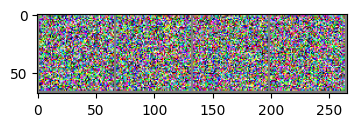

10 1.042733907699585
20 1.0143589973449707
30 0.9391114711761475
40 0.8012310266494751
50 0.6767311096191406
60 0.5447220206260681
70 0.4110869765281677
80 0.3084096610546112
90 0.21572625637054443
100 0.15216538310050964
110 0.1198841854929924
120 0.09404214471578598
130 0.08209019899368286


In [ ]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler(device)

def otfm_loss(model, x1, cond, sig_min = 0.001, eps = 1e-5): # UNetModel, [b,c,h,w], [b,cond_dim] # https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
    batch = x1.size(0)
    # t = torch.rand((batch,), device=device) % (1 - eps)
    t = logit_normal.rsample((batch,)).to(device) # in [0,1] [batch,1]
    t_ = t[...,None,None,None]
    x0 = torch.randn_like(x1)
    psi_t = (1 - (1-sig_min)*t_)*x0 + t_*x1 # ψt(x) = (1 − (1 − σmin)t)x + tx1, (22)
    v_psi = model(psi_t, t, cond) # vt(ψt(x0))
    d_psi = x1 - (1 - sig_min) * x0 #
    return F.mse_loss(v_psi, d_psi) # LCFM(θ)


def ae_train(model, optim, dataloader):
    model.train()
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
    # for i, img in enumerate(dataloader):
    #     img = img.to(device)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # x1 = F.interpolate(x1, size=(16,16)).repeat(1,3,1,1)
            # loss = otfm_loss(model, x1, cond) # unet
            # img = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
            # loss = model.ae_loss(img)

            x1 = model.ae.encode(img)
            img_ = model.ae.decode(x1)
            ae_loss = F.mse_loss(img_, img)
            loss = ae_loss

        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        if i % 10 == 0:
            print(i,loss.item())
            # print(i,ae_loss.item(), fm_loss.item())
        if i % 200 == 0:
            imshow(torchvision.utils.make_grid(img[:4].detach().cpu().to(torch.float32), nrow=4))
            imshow(torchvision.utils.make_grid(x1[:4].detach().cpu().to(torch.float32), nrow=4))
            imshow(torchvision.utils.make_grid(img_[:4].detach().cpu().to(torch.float32), nrow=4))

        try: wandb.log({"ae_loss": loss.item()})
        except NameError: pass


def train(model, optim, dataloader):
    model.train()
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
    # for i, img in enumerate(dataloader):
    #     img = img.to(device)
        # # cond = cond_emb(y)
        cond = F.one_hot(y, num_classes=10).to(torch.float)
        # x1 = F.interpolate(x1, size=(16,16)).repeat(1,3,1,1)
        img = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?

            # with torch.no_grad():
            # x1 = model.ae.encode(img)
            # img_ = model.ae.decode(x1)
            # loss = F.mse_loss(img_, img)

            # ae_loss, fm_loss = model.loss(x1, cond)
            # with torch.no_grad():
            #     x1 = model.ae.encode(img)
            #     img_ = model.ae.decode(x1)
            # fm_loss = otfm_loss(model.unet, x1.detach(), cond)
            loss = otfm_loss(model, img, cond)

        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        if i % 10 == 0:
            print(i,loss.item())
            # print(i,ae_loss.item(), fm_loss.item())
        if i % 200 == 0:
            with torch.no_grad():
                cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
                img_ = reverse_flow(model, cond, timesteps=10) # unet
                # img_ = model.sample(cond, timesteps=10) # ldm
                # x1_ = reverse_flow(model.unet, cond, timesteps=10)
                # print(x1.dtype)
                # imshow(torchvision.utils.make_grid(x1_[:4].cpu(), nrow=4))

                # img_ = model.ae.decode(x1_.float())
                # with torch.no_grad(): img_ = model.ae.decode(x1_)
                imshow(torchvision.utils.make_grid(img_[:4].cpu(), nrow=4))

        try: wandb.log({"loss": loss.item()})
        # try: wandb.log({"ae_loss": ae_loss.item(), "fm_loss": fm_loss.item()})
        except NameError: pass

for epoch in range(1):
# for epoch in range(40):
    train(model, optim, train_loader)

    # for x,y in test_loader: break
    # img = F.interpolate(x.to(device), size=(64,64)).repeat(1,3,1,1)
    # x1 = model.ae.encode(img)
    # img_ = model.ae.decode(x1)
    # imshow(torchvision.utils.make_grid(img[:4].detach().cpu().to(torch.float32), nrow=4))
    # imshow(torchvision.utils.make_grid(x1[:4].detach().cpu().to(torch.float32), nrow=4))
    # imshow(torchvision.utils.make_grid(img_[:4].detach().cpu().to(torch.float32), nrow=4))

    model.eval()
    with torch.no_grad():
        # # # cond = F.one_hot(torch.tensor([4], device=device), num_classes=10).expand(16,-1).to(torch.float)
        cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
        img_ = reverse_flow(model, cond, timesteps=10) # unet
        # img_ = model.sample(cond, timesteps=10) # ldm
        imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


In [ ]:
# @title test func

def test(model, dataloader):
    model.eval()
    total_loss=0
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
        # cond = cond_emb(y)
        cond = F.one_hot(y, num_classes=10).to(torch.float)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # x1 = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
            # ae_loss, fm_loss = model.loss(x1, cond)
            # loss = ae_loss + fm_loss
            x1 = F.interpolate(x1, size=(16,16))#.repeat(1,3,1,1)
            loss = otfm_loss(model, x1, cond) # unet
        total_loss+=loss
    print(total_loss/len(dataloader))
    # if i % 10 == 0: print(i,ae_loss.item(),fm_loss.item())
    try: wandb.log({"test_loss": loss.item()})
    # try: wandb.log({"ae_loss": ae_loss.item(), "fm_loss": fm_loss.item()})
    except: pass


# test(model, test_loader)


In [18]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="lfm", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,███▇▇▆▅▅▄▃▃▂▁▁▁
loss,0.38856


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'lfm.pkl', map_location=device).values()
# model.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'lfm.pkl')

In [ ]:
# @title WCDM
# High Fidelity Visualization of What Your Self-Supervised Representation Knows About aug 2022
# https://arxiv.org/pdf/2112.09164




In [ ]:
# # dataiter = iter(train_data)
# x,y = next(dataiter)
# # print(x)
# print(x.shape)
# x=x.unsqueeze(0)
# # x1 = F.interpolate(x, size=(16,16))#.repeat(1,3,1,1)
# x1 = F.interpolate(x, size=(64,64)).repeat(1,3,1,1)
# imshow(torchvision.utils.make_grid(x1.cpu(), nrow=4))

## save

In [ ]:
# @title U-DiT next
# https://github.com/YuchuanTian/U-DiT/blob/main/udit_models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class LayerNorm2d(nn.RMSNorm): # LayerNorm RMSNorm
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x): return super().forward(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)


class DownSampler(nn.Module):
    def __init__(self, dim, kernel_size=5, r=2):
        super().__init__()
        self.r = r
        self.layer = nn.Conv2d(dim, dim, kernel_size, 1, kernel_size//2, groups=dim)
    def forward(self, x):
        b,c,h,w = x.shape
        x = x #+ self.layer(x)
        return F.pixel_unshuffle(x.transpose(0,1), self.r).flatten(2).permute(1,2,0) # [b,c,h*r,w*r] -> [c,b*r^2,h,w] -> [b*r^2,h*w,c]
# conv res pixeldown


class DownSample_Attn(nn.Module):
    def __init__(self, dim, n_heads, r=2):
        super().__init__()
        self.dim, self.heads, self.r = dim, n_heads, r
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.lin = nn.Conv2d(dim, dim, 1)
        self.rope = RoPE(d_head, seq_len=512, base=10000)
        self.scale = d_head**-.5 # v1

        # self.downsampler = DownSampler(dim, r=r)

    def forward(self, x): # [b,c,h,w]
        # b, _, h, w = x.size()
        bchw = x.shape
        # x = self.downsampler(x) # [b, r^2, h/r*w/r, c] = [b, r^2, N, c] #  # [b*r^2, h/r*w/r, c]?

        x = x.flatten(2).transpose(-2,-1)
        q,k,v = self.qkv(x).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        q, k, v = q.unflatten(-1, (self.heads,-1)), k.unflatten(-1, (self.heads,-1)), v.unflatten(-1, (self.heads,-1)) # [b*r^2, h/r*w/r, n_heads, d_head]?
        # q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        # x = F.pixel_shuffle(x.flatten(2).permute(2,0,1).unflatten(-1, (h//self.r, w//self.r)), 2).transpose(0,1) # [b*r^2, h/r*w/r, n_heads, d_head] -> [d, b*r^2, h/r,w/r] -> [b,d,h,w]
        x = x.transpose(-2,-1).reshape(bchw) # [batch, n_heads, T/num_tok, d_head] -> [batch, n_heads*d_head, T/num_tok] -> [b,c,h,w]
        return self.lin(x)


class TimeEmb(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.rot_emb = RotEmb(emb_dim)
        self.mlp = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))
    def forward(self, t): return self.mlp(self.rot_emb(t))


class U_DiTBlock(nn.Module):
    """A IPT block with adaptive layer norm zero (adaLN-Zero) conIPTioning."""
    def __init__(self, d_model, cond_dim, n_heads, down_factor=2):
        super().__init__()
        self.d_model = d_model
        self.norm = LayerNorm2d(d_model, elementwise_affine=False, eps=1e-6)
        # self.norm = LayerNorm2d(d_model)
        self.attn = DownSample_Attn(d_model, n_heads=n_heads, r=down_factor)
        # self.mlp = FeedForward(d_model)
        self.mlp = UIB(d_model, mult=4)
        # self.mlp = ResBlock(d_model)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(cond_dim, 6 * d_model))
        )

    def forward(self, x, cond):
        # print('U_DiT blk', x.shape, self.d_model, cond.shape)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond)[...,None,None].chunk(6, dim=1) # [batch, d_model, 1, 1]
        # print('U_DiT blk', x.shape, self.d_model, shift_mlp.shape)
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        x = x + gate_mlp * self.mlp((1 + scale_mlp) * self.norm(x) + shift_mlp)
        return x

class FinalLayer(nn.Module):
    def __init__(self, d_model, out_ch):
        super().__init__()
        self.in_proj = nn.Conv2d(d_model, d_model, kernel_size=3, stride=1, padding=1)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(d_model, 2*d_model))
        )
        self.norm = LayerNorm2d(d_model, elementwise_affine=False, eps=1e-6)
        # self.norm = LayerNorm2d(d_model)
        self.out_proj = zero_module(nn.Conv2d(d_model, out_ch, kernel_size=3, stride=1, padding=1))

    def forward(self, x, cond):
        shift, scale = self.adaLN_modulation(cond)[...,None,None].chunk(2, dim=1)
        # print('FinalLayer', x.shape, shift.shape, scale.shape)
        x = self.in_proj(x)
        x = (1 + scale) * self.norm(x) + shift
        x = self.out_proj(x)
        return x


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_heads=None, d_head=8, depth=1, r=1):
        super().__init__()
        n_heads = n_heads or out_ch//d_head
        self.seq = Seq(
            UpDownBlock(in_ch, out_ch, r=min(1,r), emb_dim=emb_dim) if in_ch != out_ch or r<1 else nn.Identity(),
            # AttentionBlock(out_ch, d_head, cond_dim),
            *[U_DiTBlock(out_ch, cond_dim, n_heads) for i in range(1)],
            UpDownBlock(out_ch, out_ch, r=r, emb_dim=emb_dim) if r>1 else nn.Identity(),
        )

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)



class U_DiT(nn.Module):
    """Diffusion UNet model with a Transformer backbone."""
    def __init__(self, in_ch=3, d_model=96, out_ch=None, cond_dim=16, depth=[2,5,8,5,2], n_heads=16, d_head=4):
        super().__init__()
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.time_emb = TimeEmb(d_model*3)
        self.cond_emb = nn.Linear(cond_dim, d_model*3)
        self.in_block = nn.Conv2d(in_ch, d_model, 3, 1, 3//2)

        depth = 3
        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]
        # print(ch_list)

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 1/2) for i in range(depth-1)])
        emb_dim=None
        self.middle_block = Seq(
            UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth-1], ch_list[depth], r=1/2),
            # AttentionBlock(ch_list[depth], d_head, cond_dim=d_model),
            U_DiTBlock(ch_list[depth], cond_dim=d_model, n_heads=d_model//d_head),
            UpDownBlock(ch_list[depth], ch_list[depth-1], r=2, emb_dim=emb_dim),
            # UpDownBlock(ch_list[depth], ch_list[depth-1], r=2),
        )

        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], cond_dim=d_model, n_heads=n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, n_heads, depth=1, r=1 if i==0 else 2) for i in reversed(range(depth-1))])

        # self.out = FinalLayer(d_model, in_ch) # udit
        # # self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # # self.out = nn.Conv2d(d_model, out_ch, 3, padding = 3//2) # lucid; or prepend final res block


    def forward(self, x, t, y): # [b,c,h,w], time [b], class label [b]
        x = self.in_block(x) # (N, C, H, W)
        c123 = self.time_emb(t) + self.cond_emb(y)
        cond = c123.chunk(3, dim=1)

        blocks = []
        for i, down in enumerate(self.down_list):
            # print('U_DiT down', x.shape)
            x = down(x, cond=cond[i])
            blocks.append(x)
        # print('U_DiT mid1', x.shape)
        x = self.middle_block(x, cond=cond[-1])
        # print('U_DiT mid2', x.shape)
        for i, up in enumerate(self.up_list):
            # print('U_DiT up', x.shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, cond=cond[-1-i])

        # x = self.final_layer(x, cond=cond[0]) # (N, T, patch_size ** 2 * out_ch)
        return self.out(x)
        # return x




# def U_DiT_S(**kwargs): return U_DiT(down_factor=2, d_model=96, n_heads=4, depth=[2,5,8,5,2], mlp_ratio=2, downsampler='dwconv5', down_shortcut=1)
# def U_DiT_B:  U_DiT(d_model=192, n_heads=8,
# def U_DiT_L: U_DiT(d_model=384, n_heads=16,

cond_dim=10
model = U_DiT(in_ch=3, d_model=16, n_heads=4, depth=[1], cond_dim=cond_dim).to(device)

batch=64
# inputs = torch.rand(batch, 3, 32, 32)
inputs = torch.rand((batch, 3, 64, 64), device=device)
t = torch.rand((batch), device=device)
y = torch.rand((batch, cond_dim), device=device)

out = model(inputs, t, y)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) #
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683


# uib<res

# model.train()
# out = model(inputs, t, y)
# gt = torch.rand(1, 8, 32, 32)
# loss = torch.mean(out-gt)
# loss.backward()


In [ ]:
# @title unet me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        # self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        h = self.block1(x)
        h = self.block2(h, emb)
        return h + self.res_conv(x)

class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift

class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, cond_dim, n_head=None, d_head=8, updown=False, r=2):
        super().__init__()
        if updown=='down': in_ch = in_ch*r**2
        elif updown=='up': out_ch = out_ch*r**2
        if n_head==None: n_head = out_ch // d_head
        layers = [
            nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.rotemb = RotEmb(d_model)
        emb_dim = d_model# * 4
        self.time_emb = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))

        self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1))
        # self.init_conv = CrossEmbedLayer(in_ch, dim_out=d_model, kernel_sizes=(3, 7, 15), stride=1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7//2)

        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = ch_list[-1]*2**2 # 512
        self.middle_block = Seq(
            nn.PixelUnshuffle(2), ResBlock(ch, ch, emb_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, ch, emb_dim), nn.PixelShuffle(2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown='up') for i in reversed(range(depth))])

        # self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        t_emb = self.rotemb(t)
        emb = self.time_emb(t_emb) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)

        blocks = []
        x = self.in_block(x) if self.in_ch!=self.d_model else x
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x) #if self.out_ch!=self.d_model else x



# # # 64,64 -vae-> 16,16 -unet->
batch = 64
cond_dim=10
in_ch = 3
model = UNet(in_ch=in_ch, d_model=16, cond_dim=cond_dim, depth=3).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 5311187
# # # print(model)

# # x=torch.rand((batch,in_ch,16,16),device=device)
# x=torch.rand((batch,in_ch,64,64),device=device)
# t = torch.rand((batch,), device=device) # in [0,1] [N]
# cond=torch.rand((batch,cond_dim),device=device)
# out = model(x, t, cond)
# print(out.shape)

# optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# # # cond_emb = nn.Embedding(10, cond_dim).to(device)


In [ ]:
# @title facebookresearch/DiT
# https://github.com/facebookresearch/DiT/blob/main/models.py
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py#L58

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size), nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), nn.Linear(hidden_size, 6 * hidden_size, bias=True))

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels)
        self.adaLN_modulation = nn.Sequential(nn.SiLU(), nn.Linear(hidden_size, 2 * hidden_size))

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    def __init__(self, input_size=32, patch_size=2, in_channels=4, hidden_size=1152, depth=28,
        num_heads=16, mlp_ratio=4.0, class_dropout_prob=0.1, num_classes=1000, learn_sigma=True):
        super().__init__()
        # self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        # self.patch_size = patch_size
        # self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y): # [b,c,h,w], [b], [b]
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)


# def DiT_XL_2/4/8(**kwargs): return DiT(depth=28, hidden_size=1152, patch_size=2/4/8, num_heads=16, **kwargs)
# def DiT_L_2(**kwargs): return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)
# def DiT_B_2(**kwargs): return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)
# def DiT_S_2(**kwargs): return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)


In [ ]:
# @title baofff/U-ViT
# https://github.com/baofff/U-ViT/blob/main/libs/uvit.py#L138
import torch
import torch.nn as nn
import math
from .timm import trunc_normal_, Mlp
import einops
import torch.utils.checkpoint

if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
    ATTENTION_MODE = 'flash'
else:
    try:
        import xformers
        import xformers.ops
        ATTENTION_MODE = 'xformers'
    except:
        ATTENTION_MODE = 'math'
print(f'attention mode is {ATTENTION_MODE}')


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def patchify(imgs, patch_size):
    x = einops.rearrange(imgs, 'B C (h p1) (w p2) -> B (h w) (p1 p2 C)', p1=patch_size, p2=patch_size)
    return x


def unpatchify(x, channels=3):
    patch_size = int((x.shape[2] // channels) ** 0.5)
    h = w = int(x.shape[1] ** .5)
    assert h * w == x.shape[1] and patch_size ** 2 * channels == x.shape[2]
    x = einops.rearrange(x, 'B (h w) (p1 p2 C) -> B C (h p1) (w p2)', h=h, p1=patch_size, p2=patch_size)
    return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, L, C = x.shape

        qkv = self.qkv(x)
        if ATTENTION_MODE == 'flash':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B H L D', K=3, H=self.num_heads).float()
            q, k, v = qkv[0], qkv[1], qkv[2]  # B H L D
            x = torch.nn.functional.scaled_dot_product_attention(q, k, v)
            x = einops.rearrange(x, 'B H L D -> B L (H D)')
        elif ATTENTION_MODE == 'xformers':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B L H D', K=3, H=self.num_heads)
            q, k, v = qkv[0], qkv[1], qkv[2]  # B L H D
            x = xformers.ops.memory_efficient_attention(q, k, v)
            x = einops.rearrange(x, 'B L H D -> B L (H D)', H=self.num_heads)
        elif ATTENTION_MODE == 'math':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B H L D', K=3, H=self.num_heads)
            q, k, v = qkv[0], qkv[1], qkv[2]  # B H L D
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = (attn @ v).transpose(1, 2).reshape(B, L, C)
        else:
            raise NotImplemented

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, skip=False, use_checkpoint=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)
        self.skip_linear = nn.Linear(2 * dim, dim) if skip else None
        self.use_checkpoint = use_checkpoint

    def forward(self, x, skip=None):
        if self.use_checkpoint:
            return torch.utils.checkpoint.checkpoint(self._forward, x, skip)
        else:
            return self._forward(x, skip)

    def _forward(self, x, skip=None):
        if self.skip_linear is not None:
            x = self.skip_linear(torch.cat([x, skip], dim=-1))
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class UViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, norm_layer=nn.LayerNorm, mlp_time_embed=False, num_classes=-1,
                 use_checkpoint=False, conv=True, skip=True):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_classes = num_classes
        self.in_chans = in_chans

        self.patch_embed = PatchEmbed(patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.SiLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        ) if mlp_time_embed else nn.Identity()

        if self.num_classes > 0:
            self.label_emb = nn.Embedding(self.num_classes, embed_dim)
            self.extras = 2
        else:
            self.extras = 1

        self.pos_embed = nn.Parameter(torch.zeros(1, self.extras + num_patches, embed_dim))

        self.in_blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, use_checkpoint=use_checkpoint)
            for _ in range(depth // 2)])

        self.mid_block = Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, use_checkpoint=use_checkpoint)

        self.out_blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, skip=skip, use_checkpoint=use_checkpoint)
            for _ in range(depth // 2)])

        self.norm = norm_layer(embed_dim)
        self.patch_dim = patch_size ** 2 * in_chans
        self.decoder_pred = nn.Linear(embed_dim, self.patch_dim, bias=True)
        self.final_layer = nn.Conv2d(self.in_chans, self.in_chans, 3, padding=1) if conv else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed'}

    def forward(self, x, timesteps, y=None):
        x = self.patch_embed(x)
        B, L, D = x.shape

        time_token = self.time_embed(timestep_embedding(timesteps, self.embed_dim))
        time_token = time_token.unsqueeze(dim=1)
        x = torch.cat((time_token, x), dim=1)
        if y is not None:
            label_emb = self.label_emb(y)
            label_emb = label_emb.unsqueeze(dim=1)
            x = torch.cat((label_emb, x), dim=1)
        x = x + self.pos_embed

        skips = []
        for blk in self.in_blocks:
            x = blk(x)
            skips.append(x)

        x = self.mid_block(x)

        for blk in self.out_blocks:
            x = blk(x, skips.pop())

        x = self.norm(x)
        x = self.decoder_pred(x)
        assert x.size(1) == self.extras + L
        x = x[:, self.extras:, :]
        x = unpatchify(x, self.in_chans)
        x = self.final_layer(x)
        return x


In [ ]:
# @title U-DiT
# https://github.com/YuchuanTian/U-DiT/blob/main/udit_models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, cond=None):
        for layer in self:
            args = [x]
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

from einops import rearrange

class DownSampler(nn.Module):
    def __init__(self, dim, kernel_size=5, r=2):
        super().__init__()
        self.r = r
        self.layer = nn.Conv2d(dim, dim, kernel_size, 1, kernel_size//2, groups=dim)
    def forward(self, x):
        b,c,h,w = x.shape
        x = self.layer(x) + x # down_shortcut
        return F.pixel_unshuffle(x.transpose(0,1), self.r).flatten(2).permute(1,2,0) # [b,c,h*r,w*r] -> [c,b*r^2,h,w] -> [b*r^2,h*w,c]

# conv res pixeldown

class DownSample_Attn(nn.Module):
    def __init__(self, dim, num_heads, r=2):
        super().__init__()
        self.dim = dim
        self.heads = num_heads
        self.d_head = dim//num_heads
        head_dim = dim // num_heads
        self.r = r
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.lin = nn.Conv2d(dim, dim, 1)
        self.rope = RoPE(head_dim, seq_len=512, base=10000)
        self.scale = head_dim**-.5 # v1
        # v2
        # self.logit_scale = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)
        self.logit_scale = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1))), requires_grad=True)
        # self.logit_scale = nn.Parameter(10 * torch.ones((num_heads, 1, 1)))

        self.downsampler = DownSampler(dim, r=r)

    def forward(self, x): # [b,c,h,w]
        # b, _, h, w = x.size()
        x = self.downsampler(x) # [b, r^2, h/r*w/r, c] = [b, r^2, N, c] #  # [b*r^2, h/r*w/r, c]?

        q,k,v = self.qkv(x).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        q, k, v = q.unflatten(-1, (self.heads,-1)), k.unflatten(-1, (self.heads,-1)), v.unflatten(-1, (self.heads,-1)) # [b*r^2, h/r*w/r, n_heads, d_head]?
        # q,k,v = self.qkv(x).unflatten(-1, (self.heads,-1)).chunk(3, dim=-1) # [b, r^2, h/r*w/r, dim] # [b*r^2, h/r*w/r, dim]?
        q, k = self.rope(q), self.rope(k)

        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [batch, n_heads, T/num_tok, d_head]

        # attn = (q @ k.transpose(-2, -1)) * self.scale # v1 attention
        # attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1)) * torch.clamp(self.logit_scale, max=4.6052).exp() # v2 attention
        # # attn = attn * torch.clamp(self.logit_scale, max=100)
        # x = attn.softmax(dim=-1) @ v

        x = F.pixel_shuffle(x.flatten(2).permute(2,0,1).unflatten(-1, (h//self.r, w//self.r)), 2).transpose(0,1) # [b*r^2, h/r*w/r, n_heads, d_head] -> [d, b*r^2, h/r,w/r] -> [b,d,h,w]
        return self.lin(x)

# class FeedForward(nn.Module):
#     def __init__(self, dim, ff_mult=1):
#         super().__init__()
#         d_model = dim*ff_mult
#         self.project_in = nn.Sequential(nn.Conv2d(dim, d_model, kernel_size=1), nn.GELU())
#         self.dwconv = nn.ModuleList([
#             # nn.Conv2d(d_model, d_model, 5, 1, 5//2, groups=d_model),
#             nn.Conv2d(d_model, d_model, 3, 1, 3//2, groups=d_model),
#             nn.Conv2d(d_model, d_model, 1, 1, 1//2, groups=d_model),
#         ])
#         self.project_out = nn.Sequential(nn.Conv2d(d_model, d_model//2, kernel_size=1),
#             nn.Conv2d(d_model//2, dim, kernel_size=1))

#     def forward(self, x):
#         x = self.project_in(x) # no
#         x = x + sum([conv(x) for conv in self.dwconv])
#         x = self.project_out(x)
#         return x


# class SEBlock(nn.Module): # https://github.com/DingXiaoH/RepVGG/blob/main/se_block.py#L7
#     def __init__(self, in_ch, dim=None):
#         super().__init__()
#         dim = dim or in_ch//4
#         self.se = nn.Sequential( # [b,c,h,w] -> [b,c,1,1]
#             nn.AdaptiveAvgPool2d((1,1)),
#             nn.Conv2d(in_ch, dim, 1, 1), nn.ReLU(),
#             nn.Conv2d(dim, in_ch, 1, 1), nn.Sigmoid(),
#         )
#     def forward(self, x): # [b,c,h,w]
#         return x * self.se(x) # [b,c,h,w]

# # # https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py
# # # https://github.com/DingXiaoH/RepVGG/blob/main/repvggplus.py#L28
# class FeedForward(nn.Module):
#     def __init__(self, in_ch, out_ch=None, ff_mult=1):
#         super().__init__()
#         # d_model = dim*ff_mult
#         out_ch = out_ch or in_ch
#         self.dwconv = nn.ModuleList([
#             nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, 1, 3//2), nn.BatchNorm2d(out_ch)),
#             nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, 1, 1//2), nn.BatchNorm2d(out_ch)),
#         ])
#         self.project_out = nn.Sequential(nn.GELU(), SEBlock(out_ch, out_ch//4)) # act, SEblock

#     def forward(self, x):
#         x = x + sum([conv(x) for conv in self.dwconv])
#         x = self.project_out(x)
#         return x

# # me
class FeedForward(nn.Module):
    def __init__(self, d_model, ff_mult=1):
        super().__init__()
        # d_model = dim*ff_mult
        self.project_in = nn.Sequential(nn.BatchNorm2d(d_model), nn.GELU())
        self.dwconv = nn.ModuleList([
            nn.Conv2d(d_model, d_model, 3, 1, 3//2),
            nn.Conv2d(d_model, d_model, 1, 1, 1//2),
        ])
        # self.project_out = nn.Sequential(nn.GELU(), nn.Conv2d(d_model, dim, kernel_size=1)) # act, SEblock

    def forward(self, x):
        h = self.project_in(x) # no
        x = x + sum([conv(h) for conv in self.dwconv])
        # x = self.project_out(out)
        return x

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, emb_dim=256):
        super().__init__()
        self.rot_emb = RotEmb(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_size), nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        # nn.init.normal_(self.mlp.weight, std=0.02)
        self.mlp.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=0.02)
    def forward(self, t):
        t_freq = self.rot_emb(t)
        t_emb = self.mlp(t_freq)
        return t_emb


class U_DiTBlock(nn.Module):
    """A IPT block with adaptive layer norm zero (adaLN-Zero) conIPTioning."""
    def __init__(self, hidden_size, num_heads, down_factor=2):
        super().__init__()
        self.norm1 = LayerNorm2d(hidden_size, elementwise_affine=False, eps=1e-6)
        # self.norm1 = LayerNorm2d(hidden_size)
        self.attn = DownSample_Attn(hidden_size, num_heads=num_heads, r=down_factor)
        # self.attn = AttentionBlock(d_model=hidden_size, d_head=hidden_size//num_heads)
        self.norm2 = LayerNorm2d(hidden_size, elementwise_affine=False, eps=1e-6)
        # self.norm2 = LayerNorm2d(hidden_size)
        self.mlp = FeedForward(hidden_size)
        self.hidden_size = hidden_size
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(hidden_size, 6 * hidden_size))
        )

    def forward(self, x, cond):
        # shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond).chunk(6, dim=1)
        # x = x + gate_msa[...,None,None] * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        # x = x + gate_mlp[...,None,None] * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))

        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(cond)[...,None,None].chunk(6, dim=1)
        x = x + gate_msa * self.attn((1 + scale_msa) * self.norm(x) + shift_msa)
        x = x + gate_mlp * self.mlp((1 + scale_mlp) * self.norm(x) + shift_mlp)

        return x

def modulate(x, shift, scale):
    return x * (1 + scale[...,None,None]) + shift[...,None,None]


class FinalLayer(nn.Module):
    def __init__(self, hidden_size, out_channels):
        super().__init__()
        self.in_proj = nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(), zero_module(nn.Linear(hidden_size, 2*hidden_size))
        )
        self.norm_final = LayerNorm2d(hidden_size, elementwise_affine=False, eps=1e-6)
        # self.norm_final = LayerNorm2d(hidden_size)
        self.out_proj = zero_module(nn.Conv2d(hidden_size, out_channels, kernel_size=3, stride=1, padding=1))

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = self.in_proj(x)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.out_proj(x)
        return x

class UpDownsample(nn.Module):
    def __init__(self, n_feat, r=1):
        super().__init__()
        if r>1: sample = nn.PixelShuffle(r)
        elif r<1: sample = nn.PixelUnshuffle(int(1/r))
        else: sample = nn.Identity()
        self.body = nn.Sequential(nn.Conv2d(n_feat, int(n_feat*r), 3, 1, 1, bias=False), sample)
    def forward(self, x): return self.body(x)

class levelBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, depth=1, updown=False, red=False):
        super().__init__()

        if updown=='down': level = [
            UpDownsample(hidden_size, r=1/2),
            *[U_DiTBlock(hidden_size*2, num_heads) for _ in range(depth)]
        ]
        elif updown=='up': level = [
            # nn.Conv2d(hidden_size, hidden_size//2, kernel_size=1),
            # *[U_DiTBlock(hidden_size//2, num_heads) for _ in range(depth)],
            # UpDownsample(hidden_size//2, r=2)
            nn.Conv2d(hidden_size*2, hidden_size, kernel_size=1),
            *[U_DiTBlock(hidden_size, num_heads) for _ in range(depth)],
            UpDownsample(hidden_size, r=2)
            ]
        else: level = [
            nn.Conv2d(hidden_size*2, hidden_size, kernel_size=1) if red else nn.Identity(),
            *[U_DiTBlock(hidden_size, num_heads) for _ in range(depth)]
        ]
        self.seq = Seq(*level)

    def forward(self, x, cond):
        return self.seq(x, cond)


class U_DiT(nn.Module):
    """Diffusion UNet model with a Transformer backbone."""
    def __init__(self, in_channels=3, hidden_size=96, depth=[2,5,8,5,2], num_heads=16, cond_dim=16):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels #* 2 if learn_sigma else in_channels
        self.num_heads = num_heads

        self.x_embedder = nn.Conv2d(in_channels, hidden_size, kernel_size=3, stride=1, padding=1)
        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.bias, 0)

        self.hidden_size = hidden_size
        self.t_embedder = TimestepEmbedder(hidden_size*(1+2+4))
        self.y_embedder = nn.Linear(cond_dim, hidden_size*(1+2+4))

        self.down_list = nn.ModuleList([
            levelBlock(hidden_size, num_heads, depth=1, updown=False),
            levelBlock(hidden_size, num_heads, depth=1, updown='down'),
        ])
        self.middle_block = Seq(
            UpDownsample(hidden_size*2, r=1/2),
            # levelBlock(hidden_size*4, num_heads, depth=1, updown=False),
            *[U_DiTBlock(hidden_size*4, num_heads) for _ in range(depth[2])],
            UpDownsample(hidden_size*4, r=2),
        )
        self.up_list = nn.ModuleList([
            levelBlock(hidden_size*2, num_heads, depth=1, updown='up'),
            levelBlock(hidden_size*1, num_heads, depth=1, updown=False, red=True),
        ])

        self.final_layer = FinalLayer(hidden_size, self.out_channels)

        self.apply(self._basic_init)
    def _basic_init(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


    def forward(self, x, t, y): # [b,c,h,w], time [b], class label [b]
        x = self.x_embedder(x) # (N, C, H, W)
        c123 = self.t_embedder(t) + self.y_embedder(y)
        cond = c123.split([self.hidden_size, self.hidden_size*2, self.hidden_size*4], dim=1)

        blocks = []
        for i, down in enumerate(self.down_list):
            x = down(x, cond[i])
            blocks.append(x)
        x = self.middle_block(x, cond[-1])
        for i, up in enumerate(self.up_list):
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, cond[-2-i]) # x = up(x, blocks[-i - 1])

        x = self.final_layer(x, cond[0]) # (N, T, patch_size ** 2 * out_channels)
        return x



# def U_DiT_S(**kwargs):
#     return U_DiT(down_factor=2, hidden_size=96, num_heads=4, depth=[2,5,8,5,2], mlp_ratio=2, downsampler='dwconv5', down_shortcut=1)
# def U_DiT_B:  U_DiT(hidden_size=192, num_heads=8,
# def U_DiT_L: U_DiT(hidden_size=384, num_heads=16,

cond_dim=10
model = U_DiT(in_channels=3, hidden_size=16, num_heads=4, depth=[2,3,3,3,2], cond_dim=cond_dim).to(device)

batch=64
# inputs = torch.rand(batch, 3, 32, 32)
inputs = torch.rand((batch, 3, 64, 64), device=device)
t = torch.rand((batch), device=device)
y = torch.rand((batch, cond_dim), device=device)

# model(inputs, t, y)
# out = model(inputs, t, y)
# print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) #
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683


# model.train()
# out = model(inputs, t, y)
# gt = torch.rand(1, 8, 32, 32)
# loss = torch.mean(out-gt)
# loss.backward()


In [ ]:
# @title unet me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        h = self.block1(x)
        h = self.block2(h, emb)
        return h + self.res_conv(x)

class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift

class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, cond_dim, n_head=None, d_head=8, updown=False, r=2):
        super().__init__()
        if updown=='down': in_ch = in_ch*r**2
        elif updown=='up': out_ch = out_ch*r**2
        if n_head==None: n_head = out_ch // d_head
        layers = [
            nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head = 4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.rotemb = RotEmb(d_model)
        emb_dim = d_model# * 4
        self.time_emb = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))


        tok_dim = d_model
        # if tok_dim == None: tok_dim = d_model
        self.num_time_tokens = 2
        self.time_mlp = nn.Sequential(
            RotEmb(emb_dim, top=torch.pi, base=10000),
            nn.Linear(emb_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + self.num_time_tokens * tok_dim),
        )
        self.emb_dim, self.tok_dim = emb_dim, tok_dim
        self.cond_mlp = nn.Sequential(
            nn.LayerNorm(cond_dim), nn.Linear(cond_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + tok_dim)
        )
        self.norm_cond = nn.LayerNorm(tok_dim)
        cond_dim = tok_dim


        self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1))
        # self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1), act)
        # self.init_conv = CrossEmbedLayer(in_ch, dim_out=d_model, kernel_sizes=(3, 7, 15), stride=1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7//2)

        dim_mults = [1,2,3,4,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in dim_mults] # [128, 256, 384, 512]
        # in_out = list(zip(dims[:-1], dims[1:]))
        # for ind, (dim_in, dim_out) in enumerate(in_out):


        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = ch_list[-1]*2**2 # 512
        self.middle_block = Seq(
            nn.PixelUnshuffle(2), ResBlock(ch, ch, emb_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, ch, emb_dim), nn.PixelShuffle(2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown='up') for i in reversed(range(depth))])
        # for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):

        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        # t_emb = self.rotemb(t)
        # emb = self.time_emb(t_emb) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)





        t_hid, t_tok = self.time_mlp(t).split([self.emb_dim, self.num_time_tokens * self.tok_dim], dim=-1)
        t_tok = t_tok.reshape(t_tok.shape[0], self.num_time_tokens, self.tok_dim)
        c_hid, c_tok = self.cond_mlp(cond).split([self.emb_dim, self.tok_dim], dim=-1)
        # print('unet fwd', t_hid.shape, t_tok.shape, t.shape)

        emb = t_hid + c_hid # [batch, emb_dim]
        cond = torch.cat((t_tok, c_tok.unsqueeze(1)), dim=-2) # [b, num_toks, tok_dim]
        cond = self.norm_cond(cond)




        blocks = []
        x = self.in_block(x)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x)



# 64,64 -vae-> 16,16 -unet->
batch = 4
cond_dim=10
model = UNet(in_ch=1, d_model=16, cond_dim=cond_dim, depth=3).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# print(model)

# x=torch.rand((batch,3,16,16),device=device)
x=torch.rand((batch,1,16,16),device=device)
# y=torch.rand((batch,1,16,16),device=device)
t = torch.rand((batch,), device=device) # in [0,1] [N]
# print(t)
cond=torch.rand((batch,cond_dim),device=device)
# [2, 1, 16, 16]) torch.Size([2]) torch.Size([2, 10]
print(x.shape,t.shape,cond.shape)
out = model(x, t, cond)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3

cond_emb = nn.Embedding(10, cond_dim).to(device)
# for name, param in model.named_parameters(): print(name, param)
# optim.zero_grad()
# loss = F.mse_loss(out, y)
# loss.backward()
# optim.step()

In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self, in_ch=3, d_list=[32, 64], k_list=[7,5], act=nn.GELU(), drop=0.): # ReLU GELU SiLU
        super().__init__()
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            PixelShuffleConv(in_ch, d_list[0], k_list[0], r=1/2), nn.BatchNorm2d(d_list[0]), act,
            nn.Dropout2d(drop), PixelShuffleConv(d_list[0], d_list[1], k_list[1], r=1/2), act,
        )
    def forward(self, x): return self.conv(x) # [batch, 3,64,64] -> [batch, c,h,w]

class Deconv(nn.Module):
    def __init__(self, out_ch=3, d_list=[32, 64], k_list=[7,5], act=nn.GELU(), drop=0.): # ReLU GELU SiLU
        super().__init__()
        self.deconv = nn.Sequential(
            PixelShuffleConv(d_list[1], d_list[0], k_list[1], r=2), nn.BatchNorm2d(d_list[0]), act,
            PixelShuffleConv(d_list[0], out_ch, k_list[0], r=2),
        )
    def forward(self, x): return self.deconv(x) # [batch, c,h,w] -> [batch, 3,64,64]


class PixelAE(nn.Module):
    def __init__(self, in_ch=3, d_model=256, out_ch=None, kernels=[7,5], mult=[1]):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.d_model, self.out_ch = in_ch, d_model, out_ch
        d_list=[d_model*m for m in mult]
        in_list, out_list = [in_ch, *d_list[:-1]], [*d_list[:-1], out_ch]
        act = nn.GELU() # ReLU GELU SiLU
        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=1/2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act,) for i, (in_dim, out_dim, kernel) in enumerate(zip(in_list, out_list, kernels))], # conv,norm,act except for last layer: no norm
            # PixelShuffleConvDown(in_ch, d_list[0], 7, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvDown(d_list[0], d_list[1], 5, r=2), act,
        )
        self.decoder = nn.Sequential(
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), *(nn.BatchNorm2d(out_dim), act) if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            # PixelShuffleConvUp(d_list[1], d_list[0], 5, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvUp(d_list[0], in_ch, 7, r=2), act,
        )
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


# in_ch=3
# model_ch=16
# d_list=[16, 16] # [16,32]
# k_list=[7,5] # [7,5]
# conv = Conv(in_ch=in_ch, d_list=d_list, k_list=k_list, act=nn.ReLU()) # ReLU GELU SiLU


# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,3,64,64), device=device)
# enc = conv(input)
# print(enc.shape)
# out = deconv(enc)
# print(out.shape)


In [ ]:
# @title stable diffusion unet next
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/openaimodel.py#L413
# is from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/unet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x


class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch == None: out_ch = in_ch
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1) # og
        self.conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1), act)

    def forward(self, x): # [N,C,...]
        x = F.interpolate(x, scale_factor=2, mode="nearest") # if self.conv_dim == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        x = self.conv(x) # optional
        return x

class Downsample(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.op = nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1) # optional # stride = 2 if conv_dim != 3 else (1, 2, 2) # If 3D, then downsampling occurs in the inner-two dimensions
        self.op = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1), act)
        # self.op = avg_pool_nd(conv_dim, kernel_size=stride, stride=stride) # alternative

    def forward(self, x): # [N,C,*spatial]
        return self.op(x)


class ResBlock(nn.Module):
    def __init__(self, in_ch, temb_dim, out_ch=None, scale_shift=False, updown=False, drop=0.):
        super().__init__()
        self.temb_dim = temb_dim # number of timestep embedding channels
        if out_ch == None: out_ch = in_ch
        self.in_ch, self.out_ch = in_ch, out_ch
        self.scale_shift = scale_shift
        if updown=='up': self.h_upd, self.x_upd = Upsample(in_ch), Upsample(in_ch)
        elif updown=='down': self.h_upd, self.x_upd = Downsample(in_ch), Downsample(in_ch)
        else: self.h_upd = self.x_upd = nn.Identity()
        self.in_layers = nn.Sequential(nn.BatchNorm2d(in_ch), nn.SiLU(), self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1),) # zero
        # self.in_layers = nn.Sequential(self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1)) # no bn before FiLM
        # self.in_layers = nn.Sequential(self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.SiLU(), self.h_upd, nn.Conv2d(out_ch, out_ch, 3, padding=1)) # no bn before FiLM

        # Conv bn film act res
        self.emb_layers = nn.Sequential(nn.SiLU(), nn.Linear(temb_dim, 2 * out_ch if scale_shift else out_ch),)
        # self.emb_layers = nn.Sequential(nn.Linear(temb_dim, out_ch), nn.SiLU(), nn.Linear(out_ch, 2 * out_ch if scale_shift else out_ch),)
        self.out_layers = nn.Sequential(
            nn.BatchNorm2d(out_ch), nn.SiLU(), nn.Dropout(drop), nn.Conv2d(out_ch, out_ch, 3, padding=1),
            # nn.BatchNorm2d(out_ch), nn.SiLU(), nn.Dropout(drop), zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
        )

        if out_ch == in_ch: self.skip = nn.Identity() # no need to change chanels
        else:
            # self.skip = nn.Conv2d(in_ch, out_ch, 3, padding=1) # spatial convolution to change the channels in the skip connection
            self.skip = nn.Conv2d(in_ch, out_ch, 1) # smaller 1x1 convolution to change the channels in the skip connection

    def forward(self, x, emb): # [N, C, ...], [N, temb_dim]
        # print("res fwd x", x.shape, self.in_ch, self.out_ch)
        h = self.in_layers(x) # norm, act, h_upd, conv
        x = self.x_upd(x)
        emb_out = self.emb_layers(emb) # act, lin
        # print("res fwd h emb_out", h.shape, emb_out.shape)
        while len(emb_out.shape) < len(h.shape): emb_out = emb_out[..., None]
        if self.scale_shift: # FiLM
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h) # act, drop, conv
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return h + self.skip(x) # [N, C, ...]


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, cond_dim, n_head=None, d_head=8, updown=False, *args):
        super().__init__()
        if n_head==None: n_head = out_ch // d_head
        layers = [
            # Downsample(in_ch, out_ch) if updown=='down' else nn.Identity(),
            Downsample(in_ch) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, temb_dim, out_ch=out_ch),
            # SpatialTransformer(out_ch, n_head, d_head, depth=1, cond_dim=cond_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            Upsample(out_ch) if updown=='up' else nn.Identity(),
            # Upsample(in_ch, out_ch) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, model_ch=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head = 4):
        super().__init__()
        self.in_ch = in_ch
        self.model_ch = model_ch # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = model_ch // d_head

        self.rotemb = RotEmb(model_ch)
        temb_dim = model_ch# * 4
        self.time_emb = nn.Sequential(nn.Linear(model_ch, temb_dim), nn.SiLU(), nn.Linear(temb_dim, temb_dim))

        self.in_block = nn.Sequential(nn.Conv2d(in_ch, model_ch, 3, padding=1))
        # self.in_block = nn.Sequential(nn.Conv2d(in_ch, model_ch, 3, padding=1), act)

        ch_list = [model_ch*2**i for i in range(depth+1)] # [32, 64, 128, 256]
        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], temb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], temb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = 2*ch_list[-1] # 512
        self.middle_block = Seq(
            Downsample(ch_list[-1]),
            ResBlock(ch_list[-1], temb_dim, ch),
            # SpatialTransformer(ch, ch//d_head, d_head, cond_dim=cond_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, temb_dim, ch_list[-1]),
            Upsample(ch_list[-1]),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], temb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], temb_dim, cond_dim, updown='up') for i in reversed(range(depth))])

        self.out_block = nn.Sequential(nn.BatchNorm2d(model_ch), nn.SiLU(), nn.Conv2d(model_ch, out_ch, 3, padding=1)) # zero

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        t_emb = self.rotemb(t)
        # t_emb = timestep_embedding(t, self.model_ch, repeat_only=False)
        emb = self.time_emb(t_emb)
        # emb = emb + self.label_emb(y) # class conditioning nn.Embedding(num_classes, temb_dim)
        blocks = []
        x = self.in_block(x)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x)



# 64,64 -vae-> 16,16 -unet->
batch = 4
cond_dim=10
model = UNet(in_ch=1, model_ch=16, cond_dim=cond_dim, depth=4).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# print(model)

# # x=torch.rand((batch,3,16,16),device=device)
# x=torch.rand((batch,1,16,16),device=device)
# y=torch.rand((batch,1,16,16),device=device)
# t = torch.rand((batch,), device=device) # in [0,1] [N]
# # print(t)
# cond=torch.rand((batch,cond_dim),device=device)
# # [2, 1, 16, 16]) torch.Size([2]) torch.Size([2, 10]
# print(x.shape,t.shape,cond.shape)
# out = model(x, t, cond)
# print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# optim = torch.optim.SGD(model.parameters(), lr=1e-4) # 1e-3 3e-3

cond_emb = nn.Embedding(10, cond_dim).to(device)
# for name, param in model.named_parameters(): print(name, param)
# optim.zero_grad()
# loss = F.mse_loss(out, y)
# loss.backward()
# optim.step()

In [ ]:
# @title lucidrains imagen stuff
import torch
from torch import nn
import torch.nn.functional as F

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x


class ChanRMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.scale * self.gamma


class Parallel(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        outputs = [fn(x) for fn in self.fns]
        return sum(outputs)

class GlobalContext(nn.Module): # Global Context (GC) block
    """ basically a superior form of squeeze-excitation that is attention-esque """
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1), nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1), nn.Sigmoid()
        )

    def forward(self, x): # [b, c, h, w]
        context = self.to_k(x)
        x, context = x.flatten(2), context.flatten(2) # [b, c, h*w] ,[b,1,h*w]
        out = x @ context.softmax(dim=-1).transpose(1,2) # [b, c, 1]
        out = out.unsqueeze(-1) # [b, c, 1, 1]
        return self.net(out) # [b, dim_out, 1, 1]

class Attention(nn.Module):
    def __init__(self, dim, d_head = 64,n_heads = 8, context_dim = None, scale = 8):
        super().__init__()
        self.scale = scale
        d_model = d_head * n_heads
        self.d_model, self.n_heads, self.d_head = d_model, n_heads, d_head
        self.null_kv = nn.Parameter(torch.randn(2, 1, d_head))
        self.qkv = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, d_model + 2*d_head, bias=False))
        self.q_scale, self.k_scale = nn.Parameter(torch.ones(d_head)), nn.Parameter(torch.ones(d_head))

        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, 2*d_head)) if context_dim!=None else None
        self.to_out = nn.Sequential(nn.Linear(d_model, dim, bias = False), nn.LayerNorm(dim),)

    def forward(self, x, cond = None, mask = None, attn_bias = None): # [batch, T, d_model] = [b, hw, c], [batch, num_tok, context_dim]
        batch, T, _ = x.shape#[0]
        q, k, v = self.qkv(x).split([self.d_model, self.d_head, self.d_head], dim=-1) # [batch, T, d_model], 2*[batch, T, d_head]
        q = q.reshape(batch, T, self.n_heads, -1).transpose(1,2) # [batch, n_heads, T, d_head]

        nk, nv = self.null_kv.expand((batch,-1,-1,-1)).unbind(dim=1) # [2,1,d_head]->[batch,2,1,d_head]->[batch,1,d_head]
        k, v = torch.cat((nk, k), dim=-2), torch.cat((nv, v), dim=-2) # [batch, 1+T, d_head]

        if self.to_context!=None:
            ck, cv = self.to_context(cond).chunk(2, dim = -1) # [batch, num_tok, d_head]
            k, v = torch.cat((ck, k), dim=-2), torch.cat((cv, v), dim=-2) # [batch, num_tok+1+T, d_head]

        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1) # qk rmsnorm
        q, k = q * self.q_scale, k * self.k_scale
        k, v = k.unsqueeze(1), v.unsqueeze(1) # [batch, 1, num_tok+1+T, d_head]

        sim = q @ k.transpose(-2,-1) * self.scale # [batch, n_heads, T, num_tok+1+T]
        if attn_bias!=None: sim = sim + attn_bias # relative positional encoding (T5 style)
        if mask!=None:
            mask = F.pad(mask, (1, 0), value=True).unsqueeze(1).unsqeeze(2) # [b j] -> [b 1 1 j]
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)
        attn = sim.softmax(dim=-1) # attn = sim.softmax(dim=-1, dtype=torch.float32).to(sim.dtype)
        out = (attn @ v).transpose(1,2).flatten(2) # [batch, n_heads, T, d_head] -> [batch, T, d_model]
        return self.to_out(out)


class CrossAttention(nn.Module):
    def __init__(self, dim, context_dim = None, d_head = 64,n_heads = 8, scale = 8):
        super().__init__()
        self.scale = scale
        self.n_heads =n_heads
        d_model = d_head *n_heads
        if context_dim==None: context_dim = dim
        self.to_q = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, d_model, bias=False))
        self.to_kv = nn.Linear(context_dim, d_model * 2, bias=False)
        # self.to_kv = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, d_model * 2, bias=False))
        self.null_kv = nn.Parameter(torch.randn(2, 1, 1, d_head))
        self.q_scale, self.k_scale = nn.Parameter(torch.ones(d_head)), nn.Parameter(torch.ones(d_head))
        self.to_out = nn.Sequential(nn.Linear(d_model, dim, bias = False), nn.LayerNorm(dim))

    def forward(self, x, cond, mask = None): # [batch, T, dim]=[b, hw, c], [batch, num_tok, context_dim]
        batch, T, _ = x.shape#[0]
        _, num_tok, _ = cond.shape
        q = self.to_q(x).reshape(batch, T, self.n_heads, -1).transpose(1,2) # [batch, n_heads, T, d_head]
        k, v = self.to_kv(cond).chunk(2, dim = -1) # [batch, num_tok, d_model]
        k = k.reshape(batch, num_tok, self.n_heads, -1).transpose(1,2) # [batch, n_heads, num_tok, d_head]
        v = v.reshape(batch, num_tok, self.n_heads, -1).transpose(1,2) # [batch, n_heads, num_tok, d_head]

        nk, nv = self.null_kv.expand((batch,-1,self.n_heads,-1,-1)).unbind(dim=1) # [2,1,1,d_head]->[batch,2,n_heads,1,d_head]->[batch,n_heads,1,d_head]
        k, v = torch.cat((nk, k), dim=-2), torch.cat((nv, v), dim=-2) # [batch, n_heads, 1+num_tok, d_head]

        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1) # qk rmsnorm
        q, k = q * self.q_scale, k * self.k_scale

        sim = q @ k.transpose(-2,-1) * self.scale # [batch, n_heads, T, 1+num_tok]
        if mask!=None:
            mask = F.pad(mask, (1, 0), value=True).unsqueeze(1).unsqeeze(2) # [b j] -> [b 1 1 j]
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)
        attn = sim.softmax(dim=-1) # attn = sim.softmax(dim=-1, dtype=torch.float32).to(sim.dtype)
        out = (attn @ v).transpose(1,2).flatten(2) # [batch, n_heads, T, d_head] -> [batch, T, d_model]
        return self.to_out(out)

class CrossEmbedLayer(nn.Module):
    def __init__(self, dim_in, kernel_sizes, dim_out = None, stride = 2):
        super().__init__()
        assert all([*map(lambda t: (t % 2) == (stride % 2), kernel_sizes)])
        if dim_out==None: dim_out = dim_in
        kernel_sizes = sorted(kernel_sizes)
        dim_scales = [int(dim_out / (2 ** i)) for i in range(1, len(kernel_sizes))] # [64, 32]
        dim_scales = [*dim_scales, dim_out - sum(dim_scales)] # [64, 32, 32]
        # 1/2 + 1/4 + 1/8 + ... + 1/2^num_kernels + 1/2^num_kernels of dim_out; smaller kernel allocated more channels
        self.convs = nn.ModuleList([nn.Conv2d(dim_in, dim_scale, kernel, stride=stride, padding=(kernel-stride)//2) for kernel, dim_scale in zip(kernel_sizes, dim_scales)])

    def forward(self, x):
        return torch.cat([conv(x) for conv in self.convs], dim = 1)


def Upsample(in_ch, out_ch=None):
    if out_ch==None: out_ch = in_ch
    return nn.Sequential(nn.Interpolate(scale_factor = 2, mode = 'nearest'), nn.Conv2d(in_ch, out_ch, 3, padding=1))

class PixelShuffleUpsample(nn.Module):
    """code shared by @MalumaDev at DALLE2-pytorch for addressing checkboard artifacts https://arxiv.org/ftp/arxiv/papers/1707/1707.02937.pdf"""
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * 4, 1), nn.SiLU(), nn.PixelShuffle(2)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        self.init_conv_(self.net[0])

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o//4, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = conv_weight.repeat(4,1,1,1)
        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

def Downsample(in_ch, out_ch=None): # https://arxiv.org/abs/2208.03641 shows this is the most optimal way to downsample, named SP-conv in the paper, but basically a pixel unshuffle
    if out_ch==None: out_ch = in_ch
    return nn.Sequential(nn.PixelUnshuffle(2), nn.Conv2d(in_ch * 4, out_ch, 1)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]



def FeedForward(dim, mult = 2):
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        nn.LayerNorm(dim), nn.Linear(dim, hidden_dim, bias = False), nn.GELU(),
        nn.LayerNorm(hidden_dim), nn.Linear(hidden_dim, dim, bias = False)
    )

class TransformerBlock(nn.Module):
    def __init__(self, dim, depth = 1,n_heads = 8, d_head = 32, ff_mult = 2, context_dim = None):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim,n_heads =n_heads, d_head = d_head, context_dim = context_dim),
                FeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, cond = None):
        bchw = x.shape
        x = x.flatten(2).transpose(1, 2) # [b, c, h, w] -> [b, h*w, c]
        for attn, ff in self.layers:
            x = attn(x, cond) + x
            x = ff(x) + x
        x = x.transpose(1, 2).reshape(*bchw) # [b, h*w, c] -> [b, c, h, w]
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, tok_dim = None, emb_dim = None,n_heads=None, d_head=None):
        super().__init__()
        if tok_dim != None: self.cross_attn = CrossAttention(dim = dim_out, context_dim = tok_dim, n_heads=n_heads, d_head=d_head) # CrossAttention LinearCrossAttention
        else: self.cross_attn = None
        self.block1 = nn.Sequential(ChanRMSNorm(dim), nn.SiLU(), nn.Conv2d(dim, dim_out, 3, padding = 1))
        self.block2 = Seq(ChanRMSNorm(dim_out), scale_shift(dim_out, emb_dim) if emb_dim != None else nn.Identity(), nn.SiLU(), nn.Conv2d(dim_out, dim_out, 3, padding = 1))
        self.gca = GlobalContext(dim_in = dim_out, dim_out = dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, emb = None, cond = None):
        h = self.block1(x)
        # print('ResnetBlock fwd', h.shape)
        if self.cross_attn != None:
            bhwc = h.shape
            h = h.flatten(2).transpose(1, 2) # [b, h, w, c] -> [b, h*w, c]
            h = self.cross_attn(h, cond=cond) + h
            h = h.transpose(1, 2).reshape(*bhwc) # [b, h*w, c] -> [b, c, h, w]
        h = self.block2(h, emb)
        h = h * self.gca(h) # use_gca
        return h + self.res_conv(x)


class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb = None): # [b,c,h,w], [b,emb_dim]
        # print('scale_shift fwd', x.shape, emb.shape)
        emb = self.time_mlp(emb)[..., None, None] # [b,t_dim] -> [b,2*x_dim,1,1]
        scale, shift = emb.chunk(2, dim = 1) # [b,x_dim,1,1]
        x = x * (scale + 1) + shift
        return x



In [ ]:
# @title lucidrains imagen next
import torch
from torch import nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from einops.layers.torch import Rearrange

class UNet(nn.Module):
    def __init__(self, d_model, # 512 # base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
        c_dim = 16, # cond vec dim
        tok_dim = None, # token dim
        out_dim = None,
        dim_mults=(1, 2, 4, 8), # (1, 2, 3, 4)
        in_ch = 3, out_ch = None,
        layer_attns = True, # (False, True, True, True)
        layer_cross_attns = True, # (False, True, True, True)
        # num_resnet_blocks = 1, # 3
    ):
        super().__init__()
        self.in_ch = in_ch
        if out_ch == None: self.out_ch = in_ch
        d_head = 64
        n_heads = 8 # 8 # ideally at least 4 or 8

        self.init_conv = CrossEmbedLayer(in_ch, dim_out = d_model, kernel_sizes = (3, 7, 15), stride = 1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7 // 2)
        dims = [d_model] + [d_model * m for m in dim_mults] # [128, 128, 256, 384, 512]
        # dims = [d_model * m for m in dim_mults] # [128, 256, 384, 512]

        # time conditioning
        if tok_dim == None: tok_dim = d_model

        # embedding time for log(snr) noise from continuous version
        emb_dim = 16
        emb_dim = d_model * 4 #* (2 if lowres_cond else 1)

        # pos_emb = RotEmb(emb_dim, top=torch.pi, base=10000)
        # self.time_hiddens = nn.Sequential(pos_emb, nn.Linear(emb_dim, emb_dim), nn.SiLU())

        # self.time_cond = nn.Sequential(nn.Linear(emb_dim, emb_dim))
        # num_time_tokens = 2
        # self.time_tokens = nn.Sequential(nn.Linear(emb_dim, tok_dim * num_time_tokens), Rearrange('b (r d) -> b r d', r = num_time_tokens))
        # # self.time_tokens = nn.Sequential(nn.Linear(emb_dim, tok_dim))

        self.num_time_tokens = 2
        self.time_mlp = nn.Sequential(
            RotEmb(emb_dim, top=torch.pi, base=10000),
            nn.Linear(emb_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + self.num_time_tokens * tok_dim),
        )
        self.emb_dim, self.tok_dim = emb_dim, tok_dim


        # self.cond_tokens = nn.Linear(c_dim, tok_dim)
        # self.cond_cond = nn.Sequential(
        #     nn.LayerNorm(tok_dim), nn.Linear(tok_dim, emb_dim), nn.SiLU(),
        #     nn.Linear(emb_dim, emb_dim)
        # )
        self.cond_mlp = nn.Sequential(
            nn.Linear(c_dim, tok_dim),
            nn.LayerNorm(tok_dim), nn.Linear(tok_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + tok_dim)
        )

        self.norm_cond = nn.LayerNorm(tok_dim)

        in_out = list(zip(dims[:-1], dims[1:]))
        num_layers = len(in_out)
        # num_layers = len(dims)

        self.downs = nn.ModuleList([])
        # skip_connect_dims = [] # keep track of skip connection dimensions
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_layers - 1)
            # print('down', dim_in, dim_out)

            # skip_connect_dims.append(dim_in) # dim_out if memory_efficient
            self.downs.append(nn.ModuleList([
                # Downsample(dim_in, dim_out), # memory_efficient pre_downsample; self.downs all dim_out # Downsample cross_embed_downsample CrossEmbedLayer(dim_in, dim_out, kernel_sizes = (2, 4))
                ResnetBlock(dim_in, dim_in, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
                nn.ModuleList([ResnetBlock(dim_in, dim_in, emb_dim = emb_dim) for _ in range(0)]),
                TransformerBlock(dim = dim_in, depth = 1, ff_mult = 2, context_dim = tok_dim, n_heads=n_heads, d_head=d_head), # trans/ lintrans/ id
                Downsample(dim_in, dim_out) if not is_last else Parallel(nn.Conv2d(dim_in, dim_out, 3, padding = 1), nn.Conv2d(dim_in, dim_out, 1)) # Downsample cross_embed_downsample CrossEmbedLayer(dim_in, dim_out, kernel_sizes = (2, 4))
            ]))


        mid_dim = dims[-1]
        self.mid_block = Seq(
            ResnetBlock(mid_dim, mid_dim, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
            TransformerBlock(mid_dim, depth = 1, n_heads=n_heads, d_head=d_head), # True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
            ResnetBlock(mid_dim, mid_dim, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
        )

        self.ups = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (num_layers - 1)
            # skip_connect_dim = skip_connect_dims.pop()
            # print('up', dim_in, dim_out, skip_connect_dim)
            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out + dim_in, dim_out, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
                nn.ModuleList([ResnetBlock(dim_out + dim_in, dim_out, emb_dim = emb_dim) for _ in range(0)]),
                TransformerBlock(dim = dim_out, depth = 1, ff_mult = 2, context_dim = tok_dim, n_heads=n_heads, d_head=d_head), # trans/ lintrans/ id
                PixelShuffleUpsample(dim_out, dim_in) if not is_last else nn.Identity() # PixelShuffleUpsample Upsample ; memory_efficient upscale at last too
            ]))

        self.final_res_block = ResnetBlock(d_model, d_model, emb_dim = emb_dim) #if final_resnet_block else None
        self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3 // 2)
        def zero_init_(m):
            nn.init.zeros_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        zero_init_(self.final_conv)

    def forward(self, x, time, cond):
        # cond_images = resize_image_to(cond_images, x.shape[-1], mode = 'nearest')
        # x = torch.cat((cond_images, x), dim = 1)
        x = self.init_conv(x)
        # hiddens.append(x)

        t, t_tok = self.time_mlp(time).split([self.emb_dim, self.num_time_tokens * self.tok_dim], dim=-1)
        t_tok = t_tok.reshape(t_tok.shape[0], self.num_time_tokens, self.tok_dim)
        cond_hid, c_tok = self.cond_mlp(cond).split([self.emb_dim, self.tok_dim], dim=-1)
        # print('unet fwd', t_hid.shape, t_tok.shape, t.shape)

        t = t + cond_hid # [batch, emb_dim]
        c = torch.cat((t_tok, c_tok.unsqueeze(1)), dim=-2) # [b, num_toks, tok_dim]
        c = self.norm_cond(c)

        hiddens = []
        # for pre_downsample, init_block, resnet_blocks, attn_block, post_downsample in self.downs:
        for init_block, resnet_blocks, attn_block, post_downsample in self.downs:
            # x = pre_downsample(x)
            x = init_block(x, t, c)
            for resnet_block in resnet_blocks:
                x = resnet_block(x, t)
                hiddens.append(x)
            x = attn_block(x, c)
            hiddens.append(x)
            x = post_downsample(x)

        # print('unet fwd', x.shape, t.shape, c.shape)
        x = self.mid_block(x, t, c)

        for init_block, resnet_blocks, attn_block, upsample in self.ups:
            x = torch.cat((x, hiddens.pop() * 2**-.5), dim = 1)
            x = init_block(x, t, c)
            for resnet_block in resnet_blocks:
                x = torch.cat((x, hiddens.pop() * 2**-.5), dim = 1)
                x = resnet_block(x, t)
            x = attn_block(x, c)
            x = upsample(x)

        # x = torch.cat((x, hiddens.pop()), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

model = UNet(d_model=128, c_dim=10, in_ch=1, dim_mults = (1, 2, 3, 4)).to(device)
batch = 1
# x = torch.rand((batch, 3, 64, 64), device = device)
x = torch.rand((batch, 1,16,16), device = device)
t = torch.rand(batch, device = device)
# img_cond = torch.rand((batch, 512, 64, 64), device = device)
cond = torch.rand((batch, 10), device = device)
out = model(x, t, cond)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3


In [ ]:
# @title mit-han-lab/efficientvit dc_ae.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/efficientvit/dc_ae.py
import torch
import torch.nn as nn

def build_block(block_type, d_model, norm=None, act=None):
    if block_type == "ResBlock": return ResBlock(d_model) # ResBlock(in_ch=in_ch, out_ch=out_ch, kernel_size=3, stride=1, use_bias=(True, False), norm=(None, bn2d), act_func=(relu/silu, None),)
    # ResBlock: bn2d, relu ; EViT_GLU: trms2d, silu
    elif block_type == "EViT_GLU": return EfficientViTBlock(d_model) # EfficientViTBlock(d_model, norm=norm, act_func=act, local_module="GLUMBConv", scales=()) # EViT_GLU:scales=() ; EViTS5_GLU sana:scales=(5,)

class LevelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, depth, block_type, norm=None, act=None, updown=None):
        super().__init__()
        stage = []
        if updown=='up': stage.append(UpsampleBlock(in_ch, out_ch))
        for d in range(depth):
            # block = build_block(block_type=block_type, in_ch=d_model if d > 0 else in_ch, out_ch=d_model, norm=norm, act=act,)
            block = build_block(block_type, out_ch if updown=='up' else in_ch, norm=norm, act=act,)
            stage.append(block)
        if updown=='down': stage.append(DownsampleBlock(in_ch, out_ch))
        self.block = nn.Sequential(*stage)

    def forward(self, x):
        return self.block(x)

# stage = build_stage_main(width, depth, block_type)
# downsample_block = DownsampleBlock(width, width_list[stage_id + 1])

# upsample_block = UpsampleBlock(width_list[stage_id + 1], width)
# stage.extend(build_stage_main(width, depth, block_type, "bn2d", "silu", input_width=width))


class DownsampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # self.block = nn.Conv2d(in_ch, out_ch, 3, 2, 3//2)
        self.block = ConvPixelUnshuffleDownSampleLayer(in_ch, out_ch, kernel_size=3, r=2)
        self.shortcut_block = PixelUnshuffleChannelAveragingDownSampleLayer(in_ch, out_ch, r=2)
    def forward(self, x):
        # print("DownsampleBlock fwd", x.shape, self.block(x).shape + self.shortcut_block(x).shape)
        return self.block(x) + self.shortcut_block(x)


class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # mult=[1,2,4,4,8,8]
        # depth_list=[0,4,8,2,2,2]

        # # self.project_in = nn.Conv2d(in_ch, width_list[0], 3, 1, 3//2) # if depth_list[0] > 0:
        self.project_in = DownsampleBlock(in_ch, width_list[0]) # shortcut=None # self.project_in = ConvPixelUnshuffleDownSampleLayer(in_ch, width_list[0], kernel_size=3, r=2)

        self.stages = nn.Sequential(
            LevelBlock(width_list[0], width_list[-1], depth=depth_list[0], block_type='ResBlock', updown='down'),
            LevelBlock(width_list[-1], width_list[-1], depth=depth_list[-1], block_type='EViT_GLU', updown=None),
        )

        self.out_block = nn.Conv2d(width_list[-1], out_ch, 3, 1, 3//2)
        self.out_shortcut = PixelUnshuffleChannelAveragingDownSampleLayer(width_list[-1], out_ch, r=1)

    def forward(self, x):
        x = self.project_in(x)
        x = self.stages(x)
        # print("Encoder fwd", x.shape, self.out_block, self.out_shortcut(x).shape)
        x = self.out_block(x) + self.out_shortcut(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = ConvPixelShuffleUpSampleLayer(in_ch, out_ch, kernel_size=3, r=2)
        # self.block = InterpolateConvUpSampleLayer(in_ch=in_ch, out_ch=out_ch, kernel_size=3, r=2)
        self.shortcut_block = ChannelDuplicatingPixelUnshuffleUpSampleLayer(in_ch, out_ch, r=2)
    def forward(self, x): # [b,c,h,w] -> [b,o,2h,2w]
        print("UpsampleBlock fwd", x.shape, self.block(x).shape, self.shortcut_block(x).shape)
        return self.block(x) + self.shortcut_block(x)


class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # mult=[1,2,4,4,8,8]
        # depth_list=[0,5,10,2,2,2]

        self.in_block = nn.Conv2d(in_ch, width_list[-1], 3, 1, 3//2)
        self.in_shortcut = ChannelDuplicatingPixelUnshuffleUpSampleLayer(in_ch, width_list[-1], r=1)

        self.stages = nn.Sequential(
            LevelBlock(width_list[-1], width_list[-1], depth=depth_list[-1], block_type='EViT_GLU', updown=None),
            LevelBlock(width_list[-1], width_list[0], depth=depth_list[0], block_type='ResBlock', updown='up'),
        )

        # if depth_list[0] > 0:
        # self.project_out = nn.Sequential(
        #     nn.BatchNorm2d(width_list[0]), nn.ReLU(), nn.Conv2d(width_list[0], out_ch, 3, 1, 3//2) # norm="trms2d"
        #     )
        # else:
        self.project_out = nn.Sequential(
            nn.BatchNorm2d(width_list[0]), nn.ReLU(), UpsampleBlock(width_list[0], out_ch) # shortcut=None ; norm="trms2d"
            # nn.BatchNorm2d(width_list[0]), nn.ReLU(), ConvPixelShuffleUpSampleLayer(width_list[0], out_ch, kernel_size=3, r=2) # shortcut=None ; norm="trms2d"
        )

    def forward(self, x):
        x = self.in_block(x) + self.in_shortcut(x)
        x = self.stages(x)
        x = self.project_out(x)
        return x


class DCAE(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        self.encoder = Encoder(in_ch, out_ch, d_model, mult, depth_list)
        self.decoder = Decoder(out_ch, in_ch, d_model, mult, depth_list)

    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        return x

# https://discuss.pytorch.org/t/is-there-a-layer-normalization-for-conv2d/7595/5
# https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

in_ch=3
out_ch=3
# 3*2^2|d_model
model = DCAE(in_ch, out_ch, d_model=24, mult=[1,1], depth_list=[1,1]).to(device)
# model = Encoder(in_ch, out_ch, d_model=32, mult=[1,1], depth_list=[2,2])
# print(sum(p.numel() for p in model.project_in.parameters() if p.requires_grad)) # 896
# print(sum(p.numel() for p in model.stages.parameters() if p.requires_grad)) # 4393984
# print(sum(p.numel() for p in model.out_shortcut.parameters() if p.requires_grad)) # 0
# print(sum(p.numel() for p in model.out_block.parameters() if p.requires_grad)) # 18436
# model = Decoder(out_ch, in_ch)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
x = torch.rand((2,in_ch,64,64), device=device)
out = model(x)
print(out.shape)


In [ ]:
# @title efficientvit nn/ops.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/nn/ops.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# ConvLayer
# nn.Sequential(
#     nn.Dropout2d(dropout), nn.Conv2d(in_ch, out_ch, 3, 1, 3//2, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU()
# )

class ConvPixelUnshuffleDownSampleLayer(nn.Module): # down main [b,i,2h,2w] -> [b,o,h,w]
    def __init__(self, in_ch, out_ch, kernel_size, r):
        super().__init__()
        self.r = r
        self.conv = nn.Conv2d(in_ch, out_ch//r**2, kernel_size, 1, kernel_size//2)

    def forward(self, x): # [b,i,2h,2w] -> [b,o/4,2h,2w] -> [b,o,h,w]
        x = self.conv(x)
        x = F.pixel_unshuffle(x, self.r)
        return x

class PixelUnshuffleChannelAveragingDownSampleLayer(nn.Module): # down shortcut [b,c,2h,2w] -> [b,o,h,w]
    def __init__(self, in_ch, out_ch, r):
        super().__init__()
        self.r = r
        self.samech = SameCh(in_ch*r**2, out_ch)

    def forward(self, x): # [b,c,2h,2w] -> [b,4c,h,w] -> [b,o,4c/o,h,w] -> [b,o,h,w]
        x = F.pixel_unshuffle(x, self.r)
        x = self.samech(x)
        return x

class ChannelDuplicatingPixelUnshuffleUpSampleLayer(nn.Module): # up shortcut [b,c,h,w] -> [b,o,2h,2w]
    def __init__(self, in_ch, out_ch, r):
        super().__init__()
        self.r = r
        self.samech = SameCh(in_ch, out_ch*r**2)

    def forward(self, x): # [b,c,h,w] -> [b,c * 4o/c,h,w] -> [b,o,2h,2w]
        x = self.samech(x)
        x = F.pixel_shuffle(x, self.r)
        return x


class PixelShortcut(nn.Module): # up shortcut [b,c,h,w] -> [b,o,2h,2w]
    def __init__(self, in_ch, out_ch, r):
        super().__init__()
        self.r = r
        self.samech = SameCh(in_ch, out_ch*r**2)
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale r r # https://arxiv.org/pdf/1609.05158v2
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]

    def forward(self, x): # [b,c,h,w] -> [b,c * 4o/c,h,w] -> [b,o,2h,2w]
        # down
        x = F.pixel_unshuffle(x, self.r)
        x = self.samech(x)

        # up
        x = self.samech(x)
        x = F.pixel_shuffle(x, self.r)
        return x

class SameCh(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.repeats = out_ch//in_ch
        if out_ch//in_ch > 1:
            self.func = lambda x: x.repeat_interleave(out_ch//in_ch, dim=1) # [b,i,h,w] -> [b,o,h,w]
        elif in_ch//out_ch > 1:
            self.func = lambda x: torch.unflatten(x, 1, (out_ch, in_ch//out_ch)).mean(dim=2) # [b,i,h,w] -> [b,o,i/o,h,w] -> [b,o,h,w]
        else: print('err SameCh', in_ch, out_ch)

    def forward(self, x): # [b,c,h,w] -> [b,c * 4o/c,h,w] -> [b,o,2h,2w]
        return self.func(x)


class ConvPixelShuffleUpSampleLayer(nn.Module): # up main [b,c,h,w] -> [b,o,2h,2w]
    def __init__(self, in_ch, out_ch, kernel_size, r):
        super().__init__()
        self.r = r
        self.conv = nn.Conv2d(in_ch, out_ch*r**2, kernel_size, 1, kernel_size//2)
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, 1, kernel_size//2) # InterpolateConvUpSampleLayer

    def forward(self, x): # [b,i,h,w] -> [b,4o,h,w] -> [b,o,2h,2w]
        # x = torch.nn.functional.interpolate(x, scale_r=self.r, mode="nearest")
        x = self.conv(x)
        x = F.pixel_shuffle(x, self.r)
        return x



# block = EfficientViTBlock(in_ch, norm=norm, act_func=act, local_module="GLUMBConv", scales=()) # EViT_GLU
# self.local_module = GLUMBConv(in_ch, in_ch, expand_ratio=expand_ratio,
#     use_bias=(True, True, False), norm=(None, None, norm), act_func=(act_func, act_func, None))
class GLUMBConv(nn.Module):
    # def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, mid_channels=None, expand_ratio=4, use_bias=False, norm=(None, None, "ln2d"), act_func=("silu", "silu", None)):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, mid_channels=None, expand_ratio=4):
        super().__init__()
        mid_channels = round(in_ch * expand_ratio) if mid_channels is None else mid_channels
        # self.glu_act = build_act(act_func[1], inplace=False)
        # self.inverted_conv = ConvLayer(in_ch, mid_channels * 2, 1, use_bias=use_bias[0], norm=norm[0], act_func=act_func[0],)
        # self.depth_conv = ConvLayer(mid_channels * 2, mid_channels * 2, kernel_size, stride=stride, groups=mid_channels * 2, use_bias=use_bias[1], norm=norm[1], act_func=None,)
        self.inverted_depth_conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels*2, 1, 1, 0), nn.SiLU(),
            nn.Conv2d(mid_channels*2, mid_channels*2, 3, 1, 3//2, groups=mid_channels*2),
        )
        # self.point_conv = ConvLayer(mid_channels, out_ch, 1, use_bias=use_bias[2], norm=norm[2], act_func=act_func[2],)
        self.point_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_ch, 1, 1, 0, bias=False), nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        # x = self.inverted_conv(x)
        # x = self.depth_conv(x)
        x = self.inverted_depth_conv(x)
        x, gate = torch.chunk(x, 2, dim=1)
        x = x * nn.SiLU()(gate)
        x = self.point_conv(x)
        return x


# main_block = ResBlock(in_ch=in_ch, out_ch=out_ch, kernel_size=3, stride=1, use_bias=(True, False), norm=(None, bn2d), act_func=(relu/silu, None),)
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel_size=3, stride=1, d_model=None,
        use_bias=False, norm=("bn2d", "bn2d"), act_func=("relu6", None)):
        super().__init__()
        d_model = d_model or in_ch
        out_ch = out_ch or in_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, d_model, kernel_size, stride, kernel_size//2), nn.SiLU(),
            nn.Conv2d(d_model, out_ch, kernel_size, 1, kernel_size//2, bias=False), nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        x = x + self.conv(x)
        return x


class EfficientViTBlock(nn.Module):
    def __init__(self, in_ch, heads_ratio = 1.0, dim=32, expand_ratio=1, # expand_ratio=4
        # scales: tuple[int, ...] = (5,), # (5,): sana
        # act_func = "hswish", # nn.Hardswish()
    ):
        super().__init__()
        # self.context_module = LiteMLA(in_ch, in_ch, heads_ratio=heads_ratio, dim=dim, norm=(None, norm), scales=scales,)
        self.context_module = AttentionBlock(in_ch, d_head=8)
        # self.local_module = MBConv(
        self.local_module = GLUMBConv(in_ch, in_ch, expand_ratio=expand_ratio)

    def forward(self, x):
        x = x + self.context_module(x)
        x = x + self.local_module(x)
        return x

# class ResidualBlock(nn.Module):
    # def forward(self, x):
    #     res = self.forward_main(self.pre_norm(x)) + self.shortcut(x)
    #     res = self.post_act(res)
    #     return res


In [ ]:
# @title CrossEmbedLayer PixelShuffleConv
import torch
from torch import nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CrossEmbedLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_sizes, stride=1):
        super().__init__()
        kernel_sizes = sorted(kernel_sizes)

        r=2
        balls = out_ch//r**2
        mult = [1/(1.6**i) for i in range(len(kernel_sizes))]
        mul = balls/sum(mult)
        mult = [m*mul for m in mult]
        dim_scales = [0]*len(kernel_sizes)
        for i in range(balls):
            ind = mult.index(max(mult))
            dim_scales[ind] += 1
            mult[ind] -= 1
        dim_scales = [d*r**2 for d in dim_scales]
        if 0 in dim_scales: print('dim_scales',dim_scales)
        # 1/2 + 1/4 + 1/8 + ... + 1/2^num_kernels + 1/2^num_kernels of out_ch; smaller kernel allocated more channels
        self.convs = nn.ModuleList([nn.Conv2d(in_ch, dim_scale, kernel, stride=stride, padding=(kernel-stride)//2) for kernel, dim_scale in zip(kernel_sizes, dim_scales)])

    def forward(self, x):
        # return torch.cat([conv(x) for conv in self.convs], dim = 1)
        out = torch.cat([conv(x) for conv in self.convs], dim = 1)
        b,c,h,w = out.shape
        out = out.reshape(b, -1, 4, h, w).transpose(1,2).reshape(b, c, h, w)
        return out


class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch = None, kernel_size=3, r=2):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.out_ch, self.r = in_ch, out_ch, r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        self.net.apply(self.init_conv_)

    def init_conv_(self, conv): # weight initialisation very important for the performance of pixelshuffle!
        if isinstance(conv, nn.Conv2d):
            o, i, h, w = conv.weight.shape
            conv_weight = torch.empty(self.out_ch, self.in_ch, h, w)
            nn.init.kaiming_uniform_(conv_weight)
            # print(conv.weight.shape, conv_weight.shape,max(self.r, int(1/self.r)), (0 if self.r>1 else 1))
            conv.weight.data.copy_(conv_weight.repeat_interleave(max(self.r, int(1/self.r))**2, dim=(0 if self.r>1 else 1)))
            nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)


# d=PixelShuffleConv(3, 16, 7, r=1/2)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = PixelShuffleConv(in_ch=3, r=2).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 16x16 conv 17651 ; pixel(3)(3)  ; (1)(1)  ; (3,7,15)(3,7)  ; (3,5,7)(3,5) 42706 ; 7,5 70226
# input = torch.rand((4,3,64,64), device=device)
# out = model(input)
# print(out.shape)

# model = PixelShuffleConv(in_ch=3, r=1/2).to(device)
# out = model(input)
# print(out.shape)


